In [1]:
import time
from collections import defaultdict
import json
import math
import random
import itertools
import csv
import pickle
import importlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../data/metadata/Nilerat_matplotlib_stylesheet.mplstyle')
import matplotlib_venn

import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))  # Add the src directory to path 
import src.plots

import seaborn as sns
import dateutil
from scipy.stats import spearmanr, pearsonr, kendalltau, linregress
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, fcluster, fclusterdata

from sklearn.cluster import AgglomerativeClustering, FeatureAgglomeration
from sklearn.datasets import make_regression, make_classification
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LassoCV, LinearRegression, RidgeCV, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.cross_decomposition import PLSRegression

from sklearn.metrics import (
    classification_report,
    roc_auc_score, roc_curve, RocCurveDisplay, auc,
    confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay,
    f1_score, 
    recall_score,
    accuracy_score,
    precision_score, precision_recall_curve, precision_recall_fscore_support,)
from sklearn.model_selection import (
    cross_val_score, cross_val_predict, cross_validate,
    RepeatedKFold, RepeatedStratifiedKFold, 
    StratifiedGroupKFold, GroupKFold, StratifiedKFold,
    train_test_split, 
    GridSearchCV,
    LeaveOneGroupOut,)
import sklearn
from statsmodels.stats.multitest import fdrcorrection

print(sklearn.__version__)

1.0.2


In [2]:
colors = json.load(open(r'..\data\metadata\color_schemes.json'))
compound_superclasses = json.load(open('../data/metadata/compound_superclasses.json', 'r'))
class_abbrevs = json.load(open('../data/metadata/molec_class_abbrev.json'))

data = pd.read_csv(r'../data/processed/combined_metabolites_data_with_model_params.csv').set_index('i')
data_cols = data.filter(regex='_FBG|_RBG').columns

ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

fg = fg.drop('1091_9_FBG')

fbg_cols = fg.loc[fg['original'] & fg['quant_file']].filter(regex='FBG', axis=0).index
rbg_cols = fg.loc[fg['original'] & fg['quant_file']].filter(regex='RBG', axis=0).index

In [3]:
X = data[data_cols].T
X_scaled = pd.DataFrame(StandardScaler().fit_transform(data[data_cols].T), index=data_cols, columns=data.index)
X_id = X_scaled.loc[:, data.loc[data['ID'] != 'Unidentified'].index]
# X_id = X_id.drop(['m_104', 'm_68', 'm_135', 'm_127', 'm_115'], axis=1) # drop low conf. ID features
y_ogtt = fg.loc[data_cols, 'ogtt']

# Model errors and feature importances were originally calculated in `BJA-3.8.1`, but are now all contained in this notebook

## Quick test for one model

In [4]:
cv = RepeatedKFold(n_splits=10, n_repeats=2, random_state=1)
scoring = 'neg_mean_squared_error'

model = Lasso()
rbg_scores = cross_val_score(
    model,       
    X.loc[rbg_cols],  
    y_ogtt.loc[rbg_cols],  
    scoring='neg_mean_absolute_percentage_error',          
    cv=cv,            
    n_jobs=7,      
    error_score='raise')

fbg_scores = cross_val_score(
    model,       
    X.loc[fbg_cols],  
    y_ogtt.loc[fbg_cols],  
    scoring='neg_mean_absolute_percentage_error',          
    cv=cv,            
    n_jobs=7,      
    error_score='raise')

# Specify models


In [5]:
models = {
    'ols': LinearRegression(),
    'lasso': Lasso(alpha=30),
    'ridge': Ridge(alpha=100),
    'en'   : ElasticNet(alpha=500, l1_ratio=0.999),
    'pls'  : PLSRegression(),
    'rf'   : RandomForestRegressor(n_estimators=200, max_features=100, random_state=42),
}

# Custom train/test splitter:
1. Drop 1091 week 9 Fasted AND non-fasted sample for balance
2. select 1 random week for each of the 8 animals
3. select 2 random animals for test, 8 for train

### Custom train/test split is Set of Tuple([train_sample_indexes], [test_sample_indexes])

In [6]:
all_rats = set(ap.loc[ap['original']].index)

animal_permutations = []
# when n_test = 2, the last 2 entries in the animal_permutations sublists are the test points
n_test = 4
n_train = len(all_rats) - n_test
for perm in itertools.permutations(all_rats, r=n_test):
    train = tuple(all_rats.difference(set(perm)))
    test = perm
    animal_permutations.append([*train, *test])
num_animal_permutations = len(animal_permutations)
print(len(animal_permutations))
animal_permutations

num_permutation_repeats = 1

sample_name_to_index = {sample_name: i for i, sample_name in enumerate(X_id.index)}

fbg_splits = set()
rbg_splits = set()

random.seed(43)
for perm in animal_permutations:
    for _ in range(num_permutation_repeats):
        rbg_split = []
        fbg_split = []
        for animal in perm:
            if animal == 1091:
                 random_week = random.choice([8, 10])
            else:
                random_week = random.choice([8, 9, 10])
            rbg_sample = f'{animal}_{random_week}_RBG'
            fbg_sample = f'{animal}_{random_week}_FBG'
            
            rbg_i = sample_name_to_index[rbg_sample]
            fbg_i = sample_name_to_index[fbg_sample]
            
            rbg_split.append(rbg_i)
            fbg_split.append(fbg_i)
        rbg_split = (tuple(rbg_split[:n_train]), tuple(rbg_split[n_train:]))
        fbg_split = (tuple(fbg_split[:n_train]), tuple(fbg_split[n_train:]))
        
        rbg_splits.add(rbg_split)
        fbg_splits.add(fbg_split)
print(len(rbg_splits))
print(len(rbg_splits) == num_animal_permutations * num_permutation_repeats)


def flatten(t):
    # convert everything nested into lists
    if isinstance(t, (list, tuple)):
        return list(map(flatten, t))
    else:
        return t

rbg_splits = flatten(list(rbg_splits))
fbg_splits = flatten(list(fbg_splits))

5040
5040
True


## Test the custom train/test split

In [7]:
result = cross_validate(
    estimator=LinearRegression(),
    X=X_id, y=y_ogtt, 
    scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error'],
    cv=fbg_splits
)
print(np.median(result['test_r2']))
for x, y in custom_splits[0]:
    print(x, y)

KeyboardInterrupt: 

In [261]:
lcv = LassoCV(eps=1e-4, n_alphas=100, cv=custom_splits[0], n_jobs=7)
lcv = lcv.fit(X=X_id, y=y_ogtt)

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.565e+01, tolerance: 2.423e+01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.899e+01, tolerance: 3.835e+01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the 

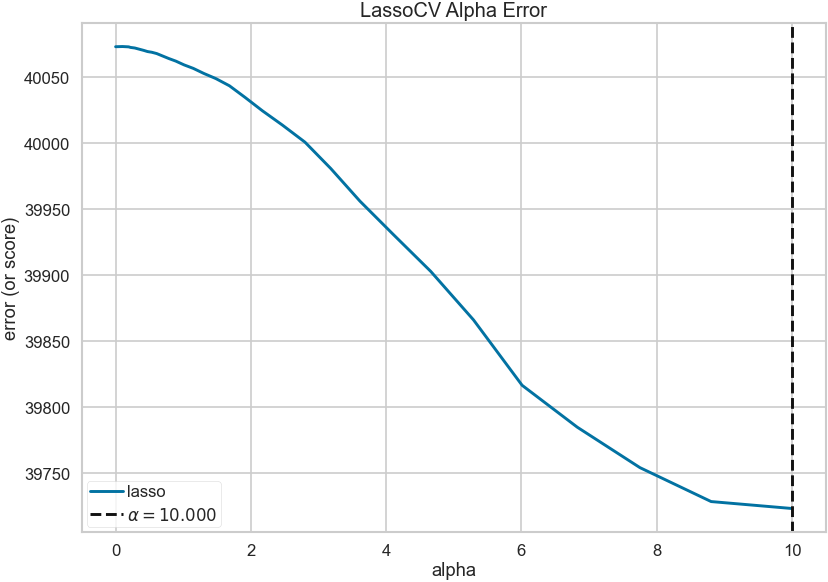

<AxesSubplot:title={'center':'LassoCV Alpha Error'}, xlabel='alpha', ylabel='error (or score)'>

In [266]:
import numpy as np

from sklearn.linear_model import LassoCV
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import AlphaSelection


# Create a list of alphas to cross-validate against
alphas = np.logspace(-10, 5, 200)

# Instantiate the linear model and visualizer
model = LassoCV(alphas=alphas, cv=custom_splits[0])
visualizer = AlphaSelection(model)
visualizer.fit(X_id, y_ogtt)
visualizer.show()

In [252]:
custom_models = {
    'ols': LinearRegression(),
    'lasso': Lasso(alpha=1),
    'ridge': Ridge(alpha=100),
    'en'   : ElasticNet(alpha=10, l1_ratio=0.9),
    'pls'  : PLSRegression(),
#     'rf'   : RandomForestRegressor(n_estimators=200, max_features=100, random_state=42),
}

random.seed(43)
subset_indexes = random.sample(range(len(rbg_splits)), 200)

custom_splits = [[rbg_splits[x] for x in subset_indexes], [fbg_splits[x] for x in subset_indexes]]

r_custom_splits = {}
for model_name, model in custom_models.items():
    r_custom_splits[model_name] = {}
    for bg_type, custom_split in zip(['rbg', 'fbg'], custom_splits):
#         coefs, rdf, median_r2 = model_cv(model, cols=cols)
        cv_result = cross_validate(
            estimator=model,
            X=X_id, y=y_ogtt,
            cv=custom_split,
            scoring=['r2', 'neg_mean_absolute_percentage_error'],
            n_jobs=7,
        )
        r_custom_splits[model_name][bg_type] = cv_result
        
for model in r_custom_splits:
    for bg_type in r_custom_splits[model]:
        d = r_custom_splits[model][bg_type]
        
        r2s = d['test_r2']
        r2_median = round(np.median(r2s), 2)
        mape_median = round(-100*np.median(d['test_neg_mean_absolute_percentage_error']), 1)

        model_name = (model + ' ' if model == 'en' else model)
        print(model_name, bg_type, '\t', r2_median, '\t', mape_median)

ols rbg 	 0.34 	 20.6
ols fbg 	 0.13 	 26.0
lasso rbg 	 0.14 	 24.5
lasso fbg 	 -0.06 	 28.9
ridge rbg 	 0.32 	 21.1
ridge fbg 	 0.05 	 27.2
en  rbg 	 0.33 	 21.5
en  fbg 	 0.05 	 26.1
pls rbg 	 0.37 	 20.6
pls fbg 	 0.15 	 26.8


In [20]:
def model_cv(model, cols, group_within_animal: bool, X_data=X_id, display_features=20, n_splits=6, n_repeats=200):
    if group_within_animal:
        X_data = X_data.loc[cols].groupby(fg['animal']).mean()
        y = y_ogtt.loc[cols].groupby(fg['animal']).mean()
    else:
        X_data = X_data.loc[cols]
        y = y_ogtt.loc[cols]
    
    cross_val = cross_validate(
        estimator=model, 
        X=X_data, 
        y=y, 
        scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error'],
        cv=RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=1),
        return_estimator=True,
        return_train_score=True,
        n_jobs=7,
    )
    rdf = pd.DataFrame(cross_val)
    try:
        raw_coefs = np.sum([estimator.coef_ for estimator in rdf['estimator']], axis=0)
    except:
        raw_coefs = np.sum([estimator.feature_importances_ for estimator in rdf['estimator']], axis=0)
    coefs = pd.DataFrame(raw_coefs, index=X_data.columns, columns=['coef'])
    coefs = coefs.div(coefs.abs().max())  # Normalize between 0 and 1
    coefs = coefs.join(data['ID'])
    coefs = coefs.sort_values('coef', ascending=False, key=abs)
    q1 = round(rdf['test_r2'].quantile(0.25), 2)
    q3 = round(rdf['test_r2'].quantile(0.75), 2)
    mean = round(rdf['test_r2'].mean(), 2)
    median = round(rdf['test_r2'].median(), 2)
    print('R2 AVERAGE: ', mean)
    print('R2 MEDIAN: ', median)
    print('R2 IQR: ', q1, q3)
    print('MSE AVERAGE: ', f"{-1*rdf['test_neg_mean_squared_error'].mean():.2E}")
    plt.hist(raw_coefs / abs(raw_coefs).max(), bins=20)
    plt.title('Model normalized coefficients')
    plt.figure()
    plt.hist(rdf['test_r2'], bins=20, range=(-1, 1))
    plt.axvline(median, zorder=10, color='black')
    plt.title('Test R2 values')
#     display(coefs.iloc[0:display_features])
    return coefs, rdf, median

# Save time by skipping the next cell and reading the `.pickle` file 

R2 AVERAGE:  0.54
R2 MEDIAN:  0.74
R2 IQR:  0.58 0.84
MSE AVERAGE:  1.04E+04
R2 AVERAGE:  0.26
R2 MEDIAN:  0.56
R2 IQR:  0.29 0.72
MSE AVERAGE:  1.67E+04
R2 AVERAGE:  0.33
R2 MEDIAN:  0.57
R2 IQR:  0.34 0.71
MSE AVERAGE:  1.71E+04
R2 AVERAGE:  0.11
R2 MEDIAN:  0.45
R2 IQR:  0.16 0.6
MSE AVERAGE:  2.07E+04
R2 AVERAGE:  0.51
R2 MEDIAN:  0.71
R2 IQR:  0.54 0.81
MSE AVERAGE:  1.17E+04
R2 AVERAGE:  0.24
R2 MEDIAN:  0.53
R2 IQR:  0.3 0.68
MSE AVERAGE:  1.76E+04
R2 AVERAGE:  -0.73
R2 MEDIAN:  -0.14
R2 IQR:  -0.47 -0.03
MSE AVERAGE:  5.07E+04


C:\Users\bjanderson23\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_axes.py:6607: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_axes.py:6608: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

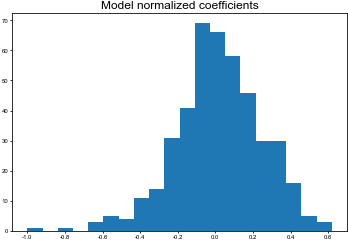

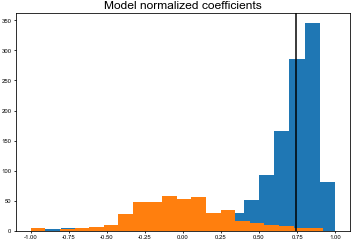

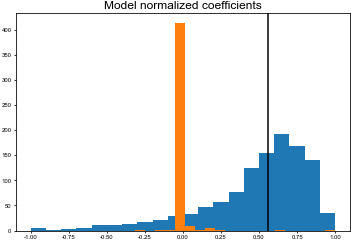

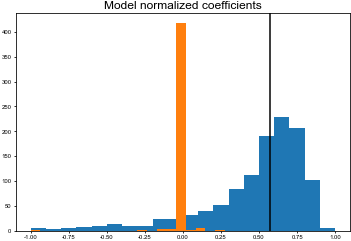

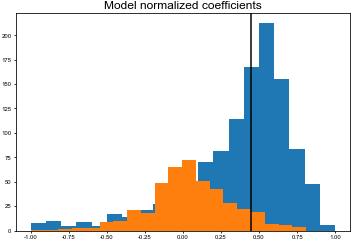

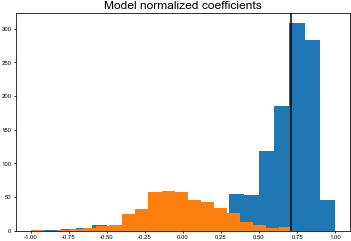

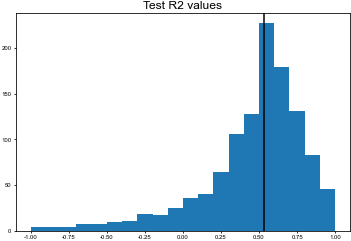

In [6]:
r = {}
for model_name, model in models.items():
    r[model_name] = {}
    for bg_type, cols in [('rbg', rbg_cols), ('fbg', fbg_cols)]:
        d = r[model_name][bg_type] = {}
        coefs, rdf, median_r2 = model_cv(model, cols=cols)
        d['coefs'] = coefs
        d['rdf'] = rdf
        d['r2'] = median_r2

In [4]:
# Save to pickle 
# with open('../data/processed/model_fits/fasted_vs_fed_models.pickle', 'wb') as f:
#     pickle.dump(r, f)
    
# Open pickle 
#### TAKES ABOUT 30 SECONDS TO READ
with open('../data/processed/model_fits/fasted_vs_fed_models.pickle', 'rb') as f:
    r = pickle.load(f)

In [5]:
r2s = [
    [r['ols']  ['rbg']['r2'],   r['ols']  ['fbg']['r2'],],
    [r['lasso']['rbg']['r2'],   r['lasso']['fbg']['r2'],],
    [r['ridge']['rbg']['r2'],   r['ridge']['fbg']['r2'],],
    [r['en']   ['rbg']['r2'],   r['en']   ['fbg']['r2'],],
    [r['pls']  ['rbg']['r2'],   r['pls']  ['fbg']['r2'],],
    [r['rf']   ['rbg']['r2'],   r['rf']   ['fbg']['r2'],],
]
r2s = pd.DataFrame(r2s, columns=['Non-fasted', 'Fasted'])
r2s['model'] = ['ols', 'lasso', 'ridge', 'en', 'pls', 'rf']
r2s = r2s.melt(value_vars=['Fasted', 'Non-fasted'], id_vars='model', value_name='R2', var_name='Sampling')
x_pos = [0, 1, 2, 3, 4, 5]
r2s['x'] = x_pos * 2
r2s

,model,Sampling,R2,x
0,ols,Fasted,0.56,0
1,lasso,Fasted,0.37,1
2,ridge,Fasted,0.53,2
3,en,Fasted,0.52,3
4,pls,Fasted,0.59,4
5,rf,Fasted,0.49,5
6,ols,Non-fasted,0.71,0
7,lasso,Non-fasted,0.46,1
8,ridge,Non-fasted,0.70,2
9,en,Non-fasted,0.67,3


## Count number of features above 0.02 coef

In [10]:
for model in models:
    for bg_type in ['rbg', 'fbg']:
        thing = r[model][bg_type]['coefs']
        
        num = len(thing.loc[thing['coef'].abs() > 0.02])
        print(model, bg_type, num)

ols rbg 412
ols fbg 412
lasso rbg 80
lasso fbg 67
ridge rbg 405
ridge fbg 409
en rbg 107
en fbg 102
pls rbg 417
pls fbg 414
rf rbg 149
rf fbg 67


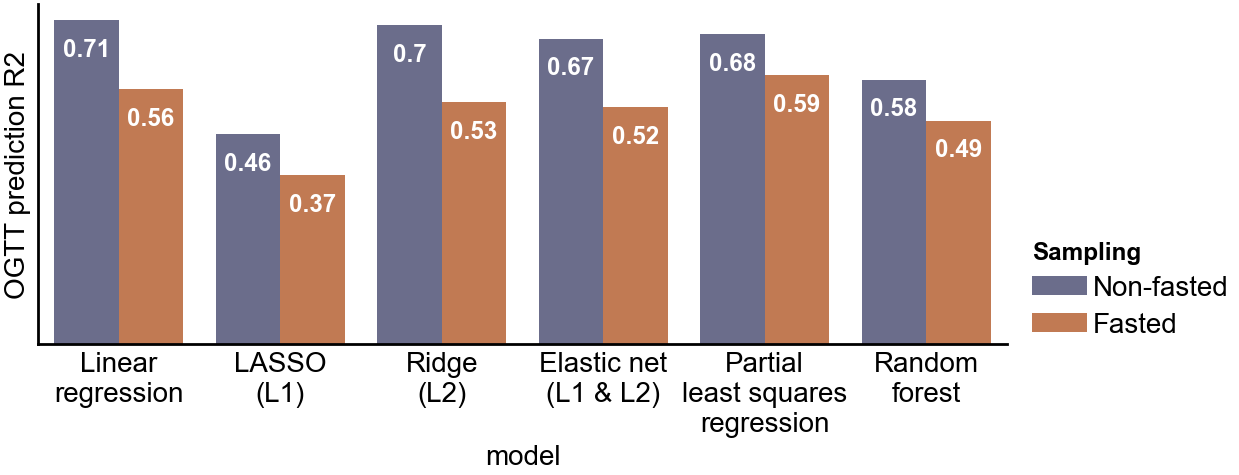

In [11]:
fig, ax = plt.subplots(dpi=250, figsize=(5, 1.8))
sns.barplot(
    data=r2s, x='model', y='R2', hue='Sampling', palette=colors, hue_order=['Non-fasted', 'Fasted'], 
    saturation=0.99, alpha=1,
)

# ax.bar(
#     x='x', height='R2', data=r2s
# )

ax.set_xticks(ax.get_xticks(), 
              labels=['Linear\nregression', 'LASSO\n(L1)', 'Ridge\n(L2)', 
                      'Elastic net\n(L1 & L2)', 'Partial\nleast squares\nregression', 'Random\nforest'])
# ax.set_yticks([0, 0.25, 0.5, 0.75])
ax.set_yticks([])
ax.tick_params(pad=2, length=0, labelsize=8)
ax.set_ylabel('OGTT prediction R2')


for i, row in r2s.iterrows():
    offset = 0.2
    x_loc = row['x'] + (-offset if row['Sampling'] == 'Non-fasted' else offset)
    r2 = row['R2']
    y_loc = r2 - 0.09
    ax.text(x_loc, y_loc, r2, color='white', fontsize=7, fontweight='bold', va='bottom', ha='center')

legend = ax.legend(
    loc=(1.02, 0), title='Sampling', 
    title_fontproperties=dict(size=src.plots.LEGEND_TITLE_FONTSIZE, weight='bold'),
#           fontsize=8, borderpad=0.5, labelspacing=0.4, handlelength=2, handletextpad=0.5
         )
legend._legend_box.align = 'left'
sns.despine()
# plt.savefig('../reports/figures/Figure6/model_R2_barplots.pdf', bbox_inches='tight', )

In [15]:
df = r['en']['rbg']['coefs']

df = df.loc[df['coef'] > 0.01]
df = df.join(data[['molec_class', 'superclass', 'Type']])
# re-normalize (because an Unidentified feature had the highest coefficient)
df['coef'] = df['coef'] / df['coef'].max()
df['i'] = df.index
df['color'] = df['superclass'].map(colors)
df['rank'] = df['coef'].rank(ascending=False)

mdf = df.loc[df['Type'] == 'metabolite']
ldf = df.loc[df['Type'] == 'lipid']

df

,coef,ID,molec_class,superclass,Type,i,color,rank
i,,,,,,,,
l_505,1.000000,Plasmanyl-PC O-20:0_20:4,Plasmanyl-PC,Phospholipid,lipid,l_505,"[0.34765625, 0.62890625, 0.3046875]",1.0
l_435,0.912957,SM d37:1,SM,Sphingolipid,lipid,l_435,"[0.9453125, 0.5546875, 0.16796875]",2.0
l_648,0.765600,TG 18:1_22:6_22:6,TG,Glycerolipid,lipid,l_648,"[0.6875, 0.4765625, 0.6328125]",3.0
l_195,0.643920,SM d36:3,SM,Sphingolipid,lipid,l_195,"[0.9453125, 0.5546875, 0.16796875]",4.0
l_794,0.630624,TG 58:7,TG,Glycerolipid,lipid,l_794,"[0.6875, 0.4765625, 0.6328125]",5.0
...,...,...,...,...,...,...,...,...
l_414,0.017967,Plasmenyl-PE P-18:0_22:6,Plasmenyl-PE,Phospholipid,lipid,l_414,"[0.34765625, 0.62890625, 0.3046875]",79.0
l_319,0.015699,PC 18:0_20:5,PC,Phospholipid,lipid,l_319,"[0.34765625, 0.62890625, 0.3046875]",80.0
l_283,0.014910,PC O-36:3,Plasmenyl-PC,Phospholipid,lipid,l_283,"[0.34765625, 0.62890625, 0.3046875]",81.0


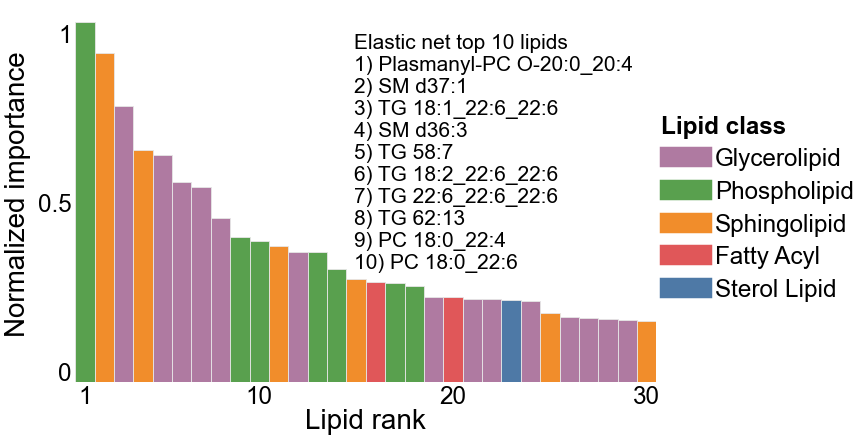

In [16]:
bdf = ldf

fig, ax = plt.subplots(dpi=250, figsize=(3, 2))
plt.bar(range(len(bdf)), bdf['coef'], color=bdf['color'], edgecolor='0.9', linewidth=0.25,
        width=1)


ax.set_xticks(ticks=[0] + list(range(9, len(bdf), 10)), 
              labels=[1] + list(range(10, len(bdf), 10)), 
              fontsize=5)
ax.set_yticks([0.03, 0.5, 0.97], [0, 0.5, 1])
ax.tick_params(length=0, pad=1, labelsize=7)
# ax.
ax.set_xlabel('Lipid rank', fontsize=8, labelpad=0)
ax.set_ylabel('Normalized importance', fontsize=8, labelpad=2)
ax.set_xlim(-0.5, 29.5)

### Add text labels to the top 10 metabolites
# for counter, (i, row) in enumerate(bdf.iloc[:10].iterrows()):
#     ax.annotate(text=row['ID'], xy=(counter, row['coef']), 
#                 xytext=(counter+5, row['coef']+0.05),
# #                 arrowprops=dict(arrowstyle='-', relpos=(0, 0.5), lw=1, color='0.5'),
#                 bbox=dict(pad=-5, facecolor='none', edgecolor='none'),
#                 fontsize=5, annotation_clip=True, ha='left', va='bottom')
### Make list of top 10
top = '\n'.join([f'{x }) {id_}' for x, id_ in zip(range(1, 11), bdf.iloc[:10]['ID'])])
top = 'Elastic net top 10 lipids\n' + top
ax.text(0.48, 0.29, top, va='bottom', ha='left', fontsize=6, transform=ax.transAxes)
    
# Make legend
handles, labels = [], []
for cls in ['Glycerolipid', 'Phospholipid', 'Sphingolipid', 'Fatty Acyl', 'Sterol Lipid']:
    handles.append(plt.matplotlib.patches.Patch(color=colors[cls]))
    labels.append(cls)
legend = ax.legend(handles, labels, loc=(1, 0.2), fontsize=7, title='Lipid class',
          title_fontproperties=dict(size=src.plots.LEGEND_TITLE_FONTSIZE, weight='bold'),
#           fontsize=6, borderpad=0.5, labelspacing=0.4, handlelength=2, handletextpad=0.5
         )
legend._legend_box.align = 'left'
sns.despine(left=True, bottom=True)
# plt.savefig('../reports/figures/Figure6/lipid_coefficients_barplot.pdf', bbox_inches='tight', facecolor='white')

# Horizontal bars comparing fasted vs fed in Elastic Net

In [10]:
corrdf = []
for i in data.index:
    fbg_corr, fbg_p = pearsonr(data.loc[i, fbg_cols], fg.loc[fbg_cols, 'ogtt'])
    rbg_corr, rbg_p = pearsonr(data.loc[i, rbg_cols], fg.loc[rbg_cols, 'ogtt'])
    corrdf.append({'i': i, 'rbg_corr': rbg_corr, 'rbg_p': rbg_p, 'fbg_corr': fbg_corr, 'fbg_p': fbg_p})
corrdf = pd.DataFrame(corrdf).set_index('i')

corrdf['rbg_q'] = fdrcorrection(corrdf['rbg_p'])[1]
corrdf['fbg_q'] = fdrcorrection(corrdf['fbg_p'])[1]


corrdf['rbg_corr_signif'] = corrdf['rbg_q'] < 0.05
corrdf['fbg_corr_signif'] = corrdf['fbg_q'] < 0.05

In [11]:
def corr_sign_signif(q, corr):
    if q > 0.05: 
        return 'ns'
    elif corr < 0:
        return '-'
    elif corr > 0:
        return '+'

corrdf['rbg_corr_sign'] = corrdf[['rbg_q', 'rbg_corr']].apply(lambda x: corr_sign_signif(x[0], x[1]), axis=1)
corrdf['fbg_corr_sign'] = corrdf[['fbg_q', 'fbg_corr']].apply(lambda x: corr_sign_signif(x[0], x[1]), axis=1)
corrdf

,rbg_corr,rbg_p,fbg_corr,fbg_p,rbg_q,fbg_q,rbg_corr_signif,fbg_corr_signif,rbg_corr_sign,fbg_corr_sign
i,,,,,,,,,,
m_0,0.546648,1.774542e-03,0.519073,0.003910,0.005187,0.036488,True,True,+,+
m_1,0.818998,3.159016e-08,0.036441,0.851133,0.000001,0.918963,True,False,+,ns
m_2,-0.142459,4.526725e-01,-0.034559,0.858745,0.559487,0.922296,False,False,ns,ns
m_3,-0.155270,4.126169e-01,-0.344277,0.067430,0.525298,0.220950,False,False,ns,ns
m_4,-0.142954,4.510871e-01,-0.419337,0.023551,0.558303,0.112484,False,False,ns,ns
...,...,...,...,...,...,...,...,...,...,...
l_912,0.684674,3.003979e-05,0.048279,0.803593,0.000203,0.895069,True,False,+,ns
l_913,0.642011,1.311126e-04,-0.218628,0.254531,0.000672,0.482684,True,False,+,ns
l_914,0.549330,1.666406e-03,-0.285556,0.133203,0.004922,0.333955,True,False,+,ns


In [12]:
alldf = r['en']['rbg']['coefs']
alldf = alldf.merge(r['en']['fbg']['coefs']['coef'], left_index=True, right_index=True, suffixes=['_rbg', '_fbg'])
alldf = alldf.join(data[['superclass', 'molec_class', 'Type']])
alldf = alldf.join(corrdf[['rbg_corr_sign', 'fbg_corr_sign']])
# alldf = alldf.drop(['m_139', 'm_107', 'm_66'])
alldf[['abs_coef_rbg', 'abs_coef_fbg']] = alldf[['coef_rbg', 'coef_fbg']].abs()
alldf['rbg_coef_sign'] = alldf['coef_rbg'].apply(lambda x: ('+' if x > 0 else '-'))
alldf['fbg_coef_sign'] = alldf['coef_fbg'].apply(lambda x: ('+' if x > 0 else '-'))

alldf = alldf.sort_values('abs_coef_rbg', ascending=False)
alldf['y_pos'] = range(0, -1*len(alldf), -1)
alldf['rbg_height'] = -1 * alldf['abs_coef_rbg']
alldf['fbg_height'] = alldf['abs_coef_fbg']

alldf['color'] = alldf['superclass'].map(colors)
# alldf.loc[alldf['Type'] == 'metabolite', 'color'] = alldf.loc[alldf['Type'] == 'metabolite', 'Type'].map(colors)
alldf.loc[alldf['Type'] == 'metabolite', 'color'] = alldf.loc[alldf['Type'] == 'metabolite', 'Type'].map({'metabolite': (0.5, 0.5, 0.5)})
alldf['color_tuples'] = alldf['color'].apply(lambda x: tuple(x))

hdf = alldf.iloc[:30]
display(hdf)

fbg_ranking_df = alldf.sort_values('abs_coef_fbg', ascending=False).iloc[:30]
fbg_ranking_df['y_pos'] = range(0, -1*len(fbg_ranking_df), -1)
fbg_ranking_df

top15_each_df = alldf.loc[hdf.iloc[:15].index.to_list() + fbg_ranking_df.iloc[:15].index.to_list()]
top15_each_df['y_pos'] = range(0, -30, -1)
top15_each_df

,coef_rbg,ID,coef_fbg,superclass,molec_class,Type,rbg_corr_sign,fbg_corr_sign,abs_coef_rbg,abs_coef_fbg,rbg_coef_sign,fbg_coef_sign,y_pos,rbg_height,fbg_height,color,color_tuples
i,,,,,,,,,,,,,,,,,
l_844,-1.000000,CE 18:1,-0.698057,Sterol Lipid,CE,lipid,-,-,1.000000,0.698057,-,-,0,-1.000000,0.698057,"[0.3046875, 0.47265625, 0.65234375]","(0.3046875, 0.47265625, 0.65234375)"
l_134,-0.842531,FA 18:0,-0.283176,Fatty Acyl,FA,lipid,ns,ns,0.842531,0.283176,-,-,-1,-0.842531,0.283176,"[0.87890625, 0.33984375, 0.34765625]","(0.87890625, 0.33984375, 0.34765625)"
l_505,0.836194,Plasmanyl-PC O-20:0_20:4,0.501785,Phospholipid,Plasmanyl-PC,lipid,+,+,0.836194,0.501785,+,+,-2,-0.836194,0.501785,"[0.34765625, 0.62890625, 0.3046875]","(0.34765625, 0.62890625, 0.3046875)"
l_435,0.763410,SM d37:1,0.000056,Sphingolipid,SM,lipid,+,ns,0.763410,0.000056,+,+,-3,-0.763410,0.000056,"[0.9453125, 0.5546875, 0.16796875]","(0.9453125, 0.5546875, 0.16796875)"
l_186,-0.676794,PC 38:7,0.016780,Phospholipid,PC,lipid,-,ns,0.676794,0.016780,-,+,-4,-0.676794,0.016780,"[0.34765625, 0.62890625, 0.3046875]","(0.34765625, 0.62890625, 0.3046875)"
l_648,0.640190,TG 18:1_22:6_22:6,0.002148,Glycerolipid,TG,lipid,+,+,0.640190,0.002148,+,+,-5,-0.640190,0.002148,"[0.6875, 0.4765625, 0.6328125]","(0.6875, 0.4765625, 0.6328125)"
l_195,0.538442,SM d36:3,0.007383,Sphingolipid,SM,lipid,+,ns,0.538442,0.007383,+,+,-6,-0.538442,0.007383,"[0.9453125, 0.5546875, 0.16796875]","(0.9453125, 0.5546875, 0.16796875)"
l_794,0.527325,TG 58:7,0.000047,Glycerolipid,TG,lipid,+,ns,0.527325,0.000047,+,+,-7,-0.527325,0.000047,"[0.6875, 0.4765625, 0.6328125]","(0.6875, 0.4765625, 0.6328125)"
m_34,-0.510718,"N6,N6,N6-Trimethyl-L-lysine",-0.004437,Amino acid derivative,Amino acid derivative,metabolite,ns,ns,0.510718,0.004437,-,-,-8,-0.510718,0.004437,"(0.5, 0.5, 0.5)","(0.5, 0.5, 0.5)"


,coef_rbg,ID,coef_fbg,superclass,molec_class,Type,rbg_corr_sign,fbg_corr_sign,abs_coef_rbg,abs_coef_fbg,rbg_coef_sign,fbg_coef_sign,y_pos,rbg_height,fbg_height,color,color_tuples
i,,,,,,,,,,,,,,,,,
l_844,-1.000000,CE 18:1,-0.698057,Sterol Lipid,CE,lipid,-,-,1.000000,0.698057,-,-,0,-1.000000,0.698057,"[0.3046875, 0.47265625, 0.65234375]","(0.3046875, 0.47265625, 0.65234375)"
l_134,-0.842531,FA 18:0,-0.283176,Fatty Acyl,FA,lipid,ns,ns,0.842531,0.283176,-,-,-1,-0.842531,0.283176,"[0.87890625, 0.33984375, 0.34765625]","(0.87890625, 0.33984375, 0.34765625)"
l_505,0.836194,Plasmanyl-PC O-20:0_20:4,0.501785,Phospholipid,Plasmanyl-PC,lipid,+,+,0.836194,0.501785,+,+,-2,-0.836194,0.501785,"[0.34765625, 0.62890625, 0.3046875]","(0.34765625, 0.62890625, 0.3046875)"
l_435,0.763410,SM d37:1,0.000056,Sphingolipid,SM,lipid,+,ns,0.763410,0.000056,+,+,-3,-0.763410,0.000056,"[0.9453125, 0.5546875, 0.16796875]","(0.9453125, 0.5546875, 0.16796875)"
l_186,-0.676794,PC 38:7,0.016780,Phospholipid,PC,lipid,-,ns,0.676794,0.016780,-,+,-4,-0.676794,0.016780,"[0.34765625, 0.62890625, 0.3046875]","(0.34765625, 0.62890625, 0.3046875)"
l_648,0.640190,TG 18:1_22:6_22:6,0.002148,Glycerolipid,TG,lipid,+,+,0.640190,0.002148,+,+,-5,-0.640190,0.002148,"[0.6875, 0.4765625, 0.6328125]","(0.6875, 0.4765625, 0.6328125)"
l_195,0.538442,SM d36:3,0.007383,Sphingolipid,SM,lipid,+,ns,0.538442,0.007383,+,+,-6,-0.538442,0.007383,"[0.9453125, 0.5546875, 0.16796875]","(0.9453125, 0.5546875, 0.16796875)"
l_794,0.527325,TG 58:7,0.000047,Glycerolipid,TG,lipid,+,ns,0.527325,0.000047,+,+,-7,-0.527325,0.000047,"[0.6875, 0.4765625, 0.6328125]","(0.6875, 0.4765625, 0.6328125)"
m_34,-0.510718,"N6,N6,N6-Trimethyl-L-lysine",-0.004437,Amino acid derivative,Amino acid derivative,metabolite,ns,ns,0.510718,0.004437,-,-,-8,-0.510718,0.004437,"(0.5, 0.5, 0.5)","(0.5, 0.5, 0.5)"


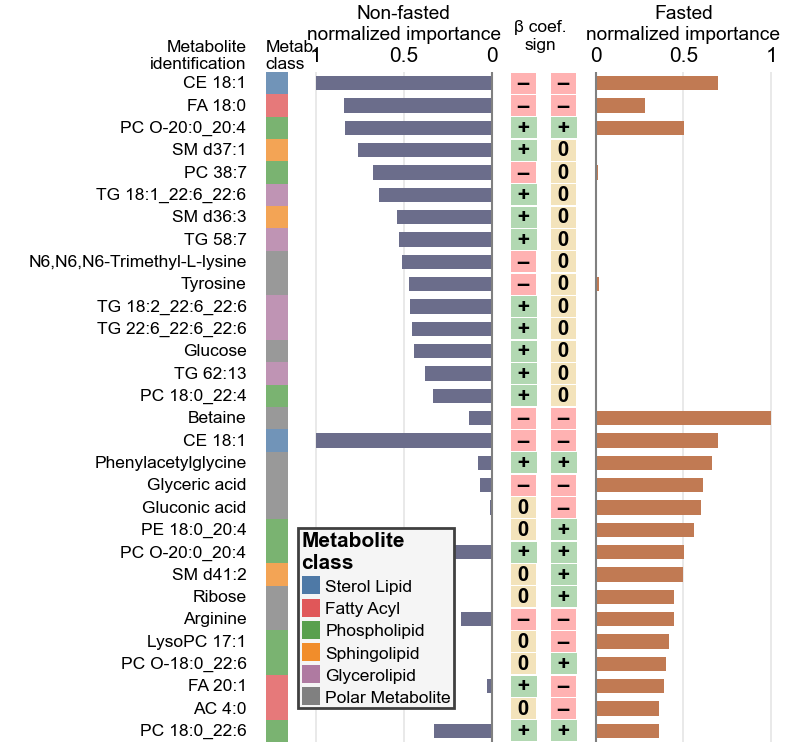

In [13]:
# set plotdf to hdf for Non-fasted ranking. 
#         set to fbg_ranking_df for Fasted ranking.
#         set to top15_each_df for Top15 Non-fasted, then top15 Fasted
plotdf = top15_each_df

importlib.reload(src.plots)
fig, (axtext, axclass, axr, axrcorr, axfcorr, axf) = plt.subplots(
    ncols=6, dpi=250, figsize=(4, 3.55), 
    gridspec_kw=dict(width_ratios=[
        0.5,  # ID name
        0.1,  # metabolite class colorbar
        0.4,  # nonfasted bar
        0.07, # nonfasted corr
        0.07, # fasted corr
        0.4,  # nonfasted bar
    ], wspace=0.05))
axs = fig.get_axes()

# https://github.com/mwaskom/seaborn/blob/d121c9cadf835bd87bc7bd48b62e837ef165ca4d/seaborn/matrix.py
plotdf['color_tuples'] = plotdf['color'].apply(lambda x: tuple(x))
matrix, cmap = sns.matrix.ClusterGrid.color_list_to_matrix_and_cmap(
    colors=plotdf['color_tuples'], 
    ind=plotdf['y_pos'].abs(), 
    axis=0)
sns.heatmap(matrix, cmap=cmap, cbar=False, square=True, xticklabels=[], yticklabels=[], ax=axclass, alpha=0.8)

for ax, name, height in ([axr, 'Non-fasted', 'abs_coef_rbg'], [axf, 'Fasted', 'abs_coef_fbg']):
    ax.barh(plotdf['y_pos'], plotdf[height], height=0.65, color=colors[name])
    ax.spines.top.set_lw(0)
    ax.tick_params(length=0)
    ax.grid(axis='x', color='0.9', lw=0.5, zorder=-10)
    ax.set_axisbelow(True)
    ax.set_xlabel(f'{name}\nnormalized importance', fontsize=5.5)
    ax.xaxis.set_label_position('top')
    ax.axvline(0, color='0.5', lw=0.6)

axf.set_xticks([0, 0.5, 1], [0, 0.5, 1])
axr.set_xticks([0, 0.5, 1], [0, 0.5, 1])
axr.set_xlim(left=1.05, right=-0.05)
axf.set_xlim(left=-0.05, right=1.05)

# PLOT TEXT AND CORRELATION SIGN
for i, row in plotdf.iterrows():
    id_text = row['ID']
    id_text = id_text.replace('Plasmanyl-', '').replace('Plasmenyl-', '')
    axtext.text(1, row['y_pos'], id_text, fontsize=5, va='center', ha='right')
    for ax, colname, coef_colname in [(axrcorr, 'rbg_coef_sign', 'coef_rbg'),   # rbg_corr_sign rbg_coef_sign
                                      (axfcorr, 'fbg_coef_sign', 'coef_fbg')]:  # fbg_corr_sign fbg_coef_sign
        sign = row[colname]
        if sign == '+': 
            color = 'green'
            sign = ' + '
        if sign == 'ns': 
            color = 'yellow'
        if abs(row[coef_colname]) < 0.02:
            color = 'goldenrod'
            sign = ' 0 '
        if sign == '-': 
            color = 'red'
            sign = ' – '  # n-dash instead of regular dash symbol
        ax.text(0.5, row['y_pos'], sign, va='center', ha='center', fontsize=6, fontweight='bold',
                bbox=dict(color=color, pad=0.3, alpha=0.3, lw=0))
#     axtext.barh(y=row['y_pos'], width=1, facecolor=row['color'], lw=1, zorder=-1, alpha=0.1)

axrcorr.text(1, 1.03, 'β coef.\nsign', fontsize=5,  va='bottom', ha='center', transform=axrcorr.transAxes)
axclass.set_title('Metab.\nclass', loc='left', fontsize=5, pad=1)
axtext.set_title('Metabolite\nidentification', loc='right', fontsize=5, pad=1)

axtext.set_xticks([]) 
axrcorr.set_xticks([])
axfcorr.set_xticks([])
    
for ax in axs:
    ax.set_yticks([])
    ax.set_ylim(top=0.5, bottom=-1*len(plotdf) + 0.5)
    sns.despine(ax=ax, left=True, top=False, bottom=True)

colors['Polar Metabolite'] = '0.5'
src.plots.custom_legend(
    entries=['Sterol Lipid', 'Fatty Acyl', 'Phospholipid', 'Sphingolipid', 'Glycerolipid', 'Polar Metabolite'], 
    palette=colors, sort=False,
    ax=axr, loc=(-0.05, 0.05), fontsize=5, title='Metabolite\nclass', title_fontsize=6,
    show_frame=True, frame_color='0.96',
    marker='s', mew=0, ms=5)
    
axclass.set_ylim(top=0, bottom=len(plotdf))
sns.despine(ax=axclass, left=True, bottom=True)
sns.despine(ax=axtext, left=True, bottom=True)
sns.despine(ax=axrcorr, left=True, bottom=True)
sns.despine(ax=axfcorr, left=True, bottom=True)
# plt.savefig('../reports/figures/Figure6/Importance_TOP15_FASTED_and_FED.pdf', 
#             bbox_inches='tight', dpi=300)

# Venn diagrams of overlap between metabs that are signif in indiv. regressions and have importance > 0.02 in elastic net

# EVEN THOUGH THIS PANEL IS IN FIGURE 5, I PUT THE CODE HERE TO PULL FROM THE SAME PICKLE FILE AS THE TRAINED MODELS

In [14]:
vdf = alldf.join(data.drop(['ID', 'superclass', 'molec_class', 'Type'], axis=1))  # [['qval_fasted', 'qval_fed', 'fa_carbons', 'fa_unsat', 'coef_fed', 'coef_fasted']]
# vdf = vdf.loc[vdf['molec_class'] != 'Unidentified']
vdf['signif_nonfasted'] = vdf['qval_fed'] < 0.05
vdf['signif_fasted'] = vdf['qval_fasted'] < 0.05
vdf['en_important_nonfasted'] = vdf['coef_rbg'].abs() > 0.02
vdf['en_important_fasted'] = vdf['coef_fbg'].abs() > 0.02
vdf

,coef_rbg,ID,coef_fbg,superclass,molec_class,Type,rbg_corr_sign,fbg_corr_sign,abs_coef_rbg,abs_coef_fbg,...,lipid_class,extra_lipid_label,fa_carbons,fa_unsat,fa_carbon:unsat,pval_asterisks,signif_nonfasted,signif_fasted,en_important_nonfasted,en_important_fasted
i,,,,,,,,,,,,,,,,,,,,,
l_844,-1.000000,CE 18:1,-0.698057,Sterol Lipid,CE,lipid,-,-,1.000000,0.698057,...,CE,NaN,18.0,1.0,18:1,ns,True,True,True,True
l_134,-0.842531,FA 18:0,-0.283176,Fatty Acyl,FA,lipid,ns,ns,0.842531,0.283176,...,FA,NaN,18.0,0.0,18:0,ns,False,False,True,True
l_505,0.836194,Plasmanyl-PC O-20:0_20:4,0.501785,Phospholipid,Plasmanyl-PC,lipid,+,+,0.836194,0.501785,...,Plasmanyl-PC,NaN,40.0,4.0,40:4,ns,True,True,True,True
l_435,0.763410,SM d37:1,0.000056,Sphingolipid,SM,lipid,+,ns,0.763410,0.000056,...,SM,37:1d,37.0,1.0,37:1,**,True,False,True,False
l_186,-0.676794,PC 38:7,0.016780,Phospholipid,PC,lipid,-,ns,0.676794,0.016780,...,PC,NaN,38.0,7.0,38:7,*,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
l_738,0.000000,TG 16:0_18:1_22:6,0.000000,Glycerolipid,TG,lipid,+,ns,0.000000,0.000000,...,TG,NaN,56.0,7.0,56:7,*,True,False,False,False
l_145,0.000000,FA 19:0,0.000000,Fatty Acyl,FA,lipid,+,ns,0.000000,0.000000,...,FA,NaN,19.0,0.0,19:0,ns,True,False,False,False
l_125,0.000000,FA 17:0,-0.049941,Fatty Acyl,FA,lipid,+,ns,0.000000,0.049941,...,FA,NaN,17.0,0.0,17:0,*,True,False,False,True


In [15]:
# fig, (ax1, ax2) = plt.subplots(nrows=2, dpi=250, figsize=(2, 2),
#     gridspec_kw=dict(hspace=0))

# subsets_fed    =    [set(vdf.loc[vdf['abs_coef_rbg'] > 0.02].index), 
#                      set(vdf.loc[vdf['signif_nonfasted']].index)]
# set_labels_fed =    ['Non-fasted Elastic Net\nBeta coef. > 0.02', 
#                      'Non-fasted individual\nregression significant']
# subsets_fasted =    [set(vdf.loc[vdf['abs_coef_fbg'] > 0.02].index), 
#                      set(vdf.loc[vdf['signif_fasted']].index)]
# set_labels_fasted = ['Fasted Elastic Net\nBeta coef. > 0.02', 
#                      'Fasted individual\nregression significant']

# v1 = matplotlib_venn.venn2(subsets_fed, set_labels_fed, ax=ax1)
# v2 = matplotlib_venn.venn2(subsets_fasted, set_labels_fasted, ax=ax2, normalize_to=0.1)

# v1.patches[0].set(fc=colors['Fed'], alpha=0.4)
# v1.patches[1].set(fc=colors['Fed'], alpha=0.4)
# v1.patches[2].set(fc=colors['Fed'], alpha=0.7)

# v2.patches[0].set(fc=colors['Fasted'], alpha=0.4)
# v2.patches[1].set(fc=colors['Fasted'], alpha=0.4)
# v2.patches[2].set(fc=colors['Fasted'], alpha=0.7)

# for v in [v1, v2]:
#     for labels in [v.set_labels, v.subset_labels]:
#         for label in labels:
#             label.set(fontsize=5)

# plt.savefig('../reports/figures/Figure5/venn_diagrams.pdf', bbox_inches='tight', dpi=300)

In [16]:
fed_both = sorted(list(subsets_fed[0].intersection(subsets_fed[1])))
bdf = data.loc[fed_both].sort_values(['Type', 'molec_class', 'fa_carbons', 'fa_unsat'],
                                     ascending=[False, False, False, False])

bdf['IDshort'] = bdf['molec_class'].map(class_abbrevs) + ' ' + bdf['fa_carbon:unsat']
bdf['IDshort'] = bdf['IDshort'].str.replace('- ', '-')
bdf.loc[bdf['Type'] == 'lipid', 'ID'] = bdf.loc[bdf['Type'] == 'lipid', 'IDshort']


fig, ax = plt.subplots(figsize=(3, 0.2), dpi=250)
for i, row in bdf.iterrows():
    ax.bar([i], 1, width=1, color=colors[row['molec_class']])
ax.set_yticks([])
ax.set_xticks(range(len(bdf)), bdf['ID'], rotation=270, ha='center')
ax.tick_params(length=0, pad=1, labelsize=3)
sns.despine(left=True, bottom=True)
# plt.savefig('../reports/figures/Figure5/Both_models_IDs.pdf', bbox_inches='tight', dpi=300)

NameError: name 'subsets_fed' is not defined

In [17]:
srrdf = pd.read_csv('../data/external/SRR table manual and auto matched.csv', index_col=0).reset_index(drop=True)
srrdf['SRR'] = srrdf['SRR (95% CI)'].str.split(' ').str[0]
srrdf['SRR 95% CI'] = srrdf['SRR (95% CI)'].str.split(' \(').str[1].str[:-1]
srrdf['manual match'] = srrdf['manual match'].replace(np.nan, '')
srrdf['match_list'] = srrdf['manual match'].apply(lambda x: x.split(';'))
srrdf = srrdf.explode('match_list')
srrdf.iloc[100:150]

,Compound,manual match,auto match,HMDB/ChEBI ID,N,SRR (95% CI),P,P-FDR,I2,tau2,...,pval_signif,qval_signif,is_lipid,auto_orig_i,auto_vali_i,Unnamed: 17,auto_vi,SRR,SRR 95% CI,match_list
99,PC 42:4,,NaN,CHEBI:66967,2,0.88 (0.83; 0.93),0.001,0.001,0,0.000,...,True,True,True,NaN,NaN,NaN,[],0.88,0.83; 0.93,
100,PC 44:3,,NaN,CHEBI:66976,2,0.92 (0.86; 1.00),0.038,0.104,0,0.000,...,True,False,True,NaN,NaN,NaN,[],0.92,0.86; 1.00,
101,PC 44:4,,NaN,CHEBI:66975,2,0.81 (0.70; 0.94),0.007,0.024,68,0.008,...,True,True,True,NaN,NaN,NaN,[],0.81,0.70; 0.94,
102,PC 44:6,,NaN,CHEBI:66973,2,0.76 (0.60; 0.96),0.020,0.064,87,0.025,...,True,False,True,NaN,NaN,NaN,[],0.76,0.60; 0.96,
103,PE 34:1,,NaN,CHEBI:155834,2,1.36 (1.08; 1.72),0.009,0.032,59,0.019,...,True,True,True,NaN,NaN,NaN,[],1.36,1.08; 1.72,
104,PE 34:2,l_327,['l_327'],CHEBI:155835,2,1.19 (1.1; 1.29),0.001,0.001,45,0.001,...,True,True,True,NaN,NaN,NaN,[],1.19,1.1; 1.29,l_327
105,PE 36:1,l_494,['l_494'],CHEBI:134451,3,1.41 (1.15; 1.74),0.001,0.005,83,0.026,...,True,True,True,NaN,NaN,NaN,['vl_3877'],1.41,1.15; 1.74,l_494
106,PE 36:2,l_422,['l_422'],CHEBI:141588,4,1.18 (1.07; 1.30),0.001,0.006,75,0.007,...,True,True,True,NaN,NaN,NaN,[],1.18,1.07; 1.30,l_422
107,PE 38:4,l_404,['l_404'],CHEBI:134270,4,1.17 (1.07; 1.28),0.001,0.002,57,0.004,...,True,True,True,NaN,NaN,NaN,['vl_3379'],1.17,1.07; 1.28,l_404
108,PE 40:6,l_372,['l_372'],CHEBI:134241,2,1.21 (1.13; 1.29),0.001,0.001,0,0.000,...,True,True,True,NaN,NaN,NaN,[],1.21,1.13; 1.29,l_372


In [39]:
fdf = (vdf
#  .loc[vdf['signif_nonfasted'] | 
#       vdf['signif_fasted'] | 
#       vdf['en_important_nonfasted'] | 
#       vdf['en_important_fasted']]
 .sort_values(['Type', 'superclass', 'molec_class', 'fa_carbons', 'fa_unsat'])
)
# display(fdf)
fdf['i'] = fdf.index
fdf = fdf.merge(srrdf, how='left', left_index=True, right_on='match_list').iloc[:-1]
fdf = fdf.set_index('i')
fdf['order'] = fdf.index.str[2:].astype('int')
# fdf = fdf.sort_values(['Type', 'superclass', 'molec_class', 'fa_carbons', 'fa_unsat'])
fdf = fdf.sort_values(['Type', 'order'])

fdf = fdf[['ID',
           'abs_coef_fbg', 'abs_coef_rbg', 'fbg_coef_sign', 'rbg_coef_sign',
           'qval_fed', 'pval_fed', 'coef_fed',
           'qval_fasted', 'pval_fasted', 'coef_fasted',
           'SRR', 'SRR 95% CI', 'P', 'P-FDR']]

def indiv_association(row, fed_or_fasted):
    if row[f'qval_{fed_or_fasted}'] > 0.05:
        return 'Not significant'
    elif row[f'coef_{fed_or_fasted}'] > 0:
        return 'Positive'
    else:
        return 'Negative'

def human_association(row):
    if row['P-FDR'] > 0.05:
        return 'Not significant'
    elif row['SRR'] > 1:
        return 'Increased'
    elif row['SRR'] < 1:
        return 'Decreased'
    else:
        return 'Not in human SRR analysis'
fdf['SRR'] = fdf['SRR'].astype(float)
fdf.insert(1, 'Human association to T2D incidence', fdf.apply(human_association, axis=1))
fdf.insert(2, 'Nile rat non-fasted association to OGTT glucAUC', 
           fdf.apply(lambda x: indiv_association(x, 'fed'), axis=1))
fdf.insert(3, 'Nile rat fasted association to OGTT glucAUC', 
           fdf.apply(lambda x: indiv_association(x, 'fasted'), axis=1))
fdf = fdf.drop(['coef_fed', 'coef_fasted'], axis=1)
fdf.rename({
    'P': 'SRR p-value','P-FDR': 'SRR q-value', 
    'abs_coef_fbg': 'Elastic net fasted importance', 'fbg_coef_sign': 'Elastic net fasted coefficient sign',
    'abs_coef_rbg': 'Elastic net non-fasted importance', 'rbg_coef_sign': 'Elastic net non-fasted coefficient sign',
    
    'qval_fed': 'Nonfasted indiv linear model q-value',
    'pval_fed': 'Nonfasted indiv linear model p-value',
    
    'qval_fasted': 'Fasted indiv linear model q-value',
    'pval_fasted': 'Fasted indiv linear model p-value',
    
    'ID': 'Annotation',
           }, 
           axis=1, inplace=True)

# fdf.to_csv('../data/processed/supplemental_table_modeling_results.csv')
fdf

,Annotation,Human association to T2D incidence,Nile rat non-fasted association to OGTT glucAUC,Nile rat fasted association to OGTT glucAUC,Elastic net fasted importance,Elastic net non-fasted importance,Elastic net fasted coefficient sign,Elastic net non-fasted coefficient sign,Nonfasted indiv linear model q-value,Nonfasted indiv linear model p-value,Fasted indiv linear model q-value,Fasted indiv linear model p-value,SRR,SRR 95% CI,SRR p-value,SRR q-value
i,,,,,,,,,,,,,,,,
l_0,AC 5:0,Increased,Not significant,Negative,0.049724,0.000000,-,-,0.917215,0.880110,0.045434,0.005450,1.13,1.08; 1.18,0.001,0.001
l_1,AC 4:0,Not significant,Negative,Negative,0.360924,0.000000,-,-,0.012212,0.004767,0.002053,0.000035,0.97,0.88; 1.06,0.473,0.606
l_2,AC 3:0,Not significant,Not significant,Not significant,0.000000,0.000000,-,-,0.138565,0.081231,0.149438,0.036485,1.06,0.98; 1.14,0.131,0.256
l_3,AC 2:0,Not significant,Not significant,Negative,0.029939,0.000000,-,-,0.089776,0.047914,0.010429,0.000632,1.00,0.94; 1.07,0.993,0.998
l_4,AC 18:2,Not significant,Not significant,Negative,0.000000,0.000000,-,-,0.651916,0.549201,0.035294,0.003757,1.08,0.88; 1.31,0.471,0.605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m_133,3-Methylhistidine,Not in human SRR analysis,Not significant,Not significant,0.000000,0.000000,-,-,0.794607,0.718473,0.131714,0.030553,NaN,NaN,NaN,NaN
m_136,3-Hydroxybutyric acid,Increased,Not significant,Negative,0.000000,0.000000,-,-,0.246773,0.163406,0.025608,0.002145,1.36,1.18; 1.56,0.001,0.001
m_138,2-Naphthalenesulfonic acid,Not in human SRR analysis,Not significant,Not significant,0.187349,0.000581,-,+,0.089757,0.047841,0.055150,0.007867,NaN,NaN,NaN,NaN


In [21]:
fdf.loc[fdf['Annotation'] == 'PC 40:6']

,Annotation,Human association to T2D incidence,Nile rat non-fasted association to OGTT glucAUC,Nile rat fasted association to OGTT glucAUC,Elastic net fasted importance,Elastic net non-fasted importance,Elastic net fasted coefficient sign,Elastic net non-fasted coefficient sign,Nonfasted indiv linear model q-value,Nonfasted indiv linear model p-value,Fasted indiv linear model q-value,Fasted indiv linear model p-value,SRR,SRR 95% CI,SRR p-value,SRR q-value
i,,,,,,,,,,,,,,,,
l_427,PC 40:6,Not significant,Positive,Not significant,0.027183,0.011731,+,+,0.00103,0.00024,0.316917,0.121458,1.05,0.97; 1.13,0.266,0.411


# Find subset with agreement between human SRR and nile rat Non-fasted individual linear models
## Find where both are significant, and have same direction 

In [22]:
both.loc[both['Annotation'].str.contains('TG')].shape

NameError: name 'both' is not defined

In [37]:
data.loc[data['ID'].isin(['SM d40:7', 'PC 38:7', 'PC 40:6', 'FA 18:2', 'FA 20:2', 'SM d32:1']), 
         ['ID', 'qval_fed']]

,ID,qval_fed
i,,
l_92,FA 18:2,0.089156
l_98,FA 18:2,0.082507
l_122,FA 20:2,0.048514
l_124,FA 20:2,0.129063
l_163,SM d32:1,0.727941
l_166,SM d40:7,0.000089
l_186,PC 38:7,0.003958
l_188,PC 38:7,0.510474
l_197,PC 38:7,0.160205


In [27]:
fdf.loc[
    (fdf['Elastic net non-fasted importance'] > 0.02) & 
    (fdf['Nonfasted indiv linear model q-value'] < 0.05) 
#     & (fdf['SRR q-value'].isna())
].iloc[:60]

,Annotation,Human association to T2D incidence,Nile rat non-fasted association to OGTT glucAUC,Nile rat fasted association to OGTT glucAUC,Elastic net fasted importance,Elastic net non-fasted importance,Elastic net fasted coefficient sign,Elastic net non-fasted coefficient sign,Nonfasted indiv linear model q-value,Nonfasted indiv linear model p-value,Fasted indiv linear model q-value,Fasted indiv linear model p-value,SRR,SRR 95% CI,SRR p-value,SRR q-value
i,,,,,,,,,,,,,,,,
l_109,FA 16:0,Not in human SRR analysis,Positive,Not significant,0.000005,0.031407,-,+,3.301683e-02,1.499700e-02,0.855691,7.145596e-01,NaN,NaN,NaN,NaN
l_123,FA 24:5,Not in human SRR analysis,Positive,Not significant,0.000227,0.195647,+,+,1.951488e-05,1.551218e-06,0.059696,9.278533e-03,NaN,NaN,NaN,NaN
l_142,FA 20:1,Not in human SRR analysis,Positive,Not significant,0.391558,0.026196,-,+,1.802735e-02,7.574301e-03,0.055877,8.010761e-03,NaN,NaN,NaN,NaN
l_146,PC 34:3,Not significant,Positive,Not significant,0.005087,0.042688,+,+,8.794192e-04,1.972296e-04,0.199921,5.675552e-02,0.97,0.83; 1.14,0.702,0.801
l_164,PC 36:3,Not significant,Positive,Not significant,0.000000,0.228780,-,+,3.372790e-04,5.553494e-05,0.403336,1.826317e-01,1.00,0.92; 1.08,0.943,0.978
l_166,SM d40:7,Not in human SRR analysis,Positive,Positive,0.135448,0.238777,+,+,8.933742e-05,1.034582e-05,0.003642,1.043549e-04,NaN,NaN,NaN,NaN
l_175,PC 42:10,Not in human SRR analysis,Positive,Not significant,0.088043,0.056795,+,+,1.613368e-03,4.225215e-04,0.054957,7.604095e-03,NaN,NaN,NaN,NaN
l_186,PC 38:7,Not in human SRR analysis,Negative,Not significant,0.016780,0.676794,+,-,3.957840e-03,1.280367e-03,0.421500,2.007284e-01,NaN,NaN,NaN,NaN
l_195,SM d36:3,Decreased,Positive,Not significant,0.007383,0.538442,+,+,1.262830e-04,1.678907e-05,0.252444,8.474531e-02,0.86,0.79; 0.93,0.001,0.001


In [24]:
both = fdf.loc[
    (
        ((fdf['Human association to T2D incidence'] == 'Increased') & (fdf['Nile rat non-fasted association to OGTT glucAUC'] == 'Positive')) 
            |
        ((fdf['Human association to T2D incidence'] == 'Decreased') & (fdf['Nile rat non-fasted association to OGTT glucAUC'] == 'Negative'))
    )
        & 
    (fdf['Elastic net non-fasted importance'] > 0.02)
].copy()

# both = both.join(data[['fa_carbons', 'fa_unsat']])
both['sum_comp'] = both['Annotation'].apply(lambda x: src.utils.parse_lipid(x)[4])
both = both.join(data[['molec_class', 'fa_carbons', 'fa_unsat']])
both = both.sort_values(['molec_class', 'fa_carbons', 'fa_unsat'])
both#['Annotation'].to_clipboard(index=False)

both[['Annotation', 'sum_comp']]

,Annotation,sum_comp
i,,
m_58,Isoleucine,NaN
m_97,Betaine,NaN
l_424,PC 18:0_20:3,38:3
l_503,SM d39:1,39:1
l_835,TG 16:0_16:0_16:0,48:0
l_873,TG 16:0_16:0_18:0,50:0
l_797,TG 56:6,56:6


## Assemble a data table of all the metabolites found in any of the circles of the venn diagrams

### Give columns nice names with their importance values and slope significances

### Export the table and manually align 

In [233]:
vdf.columns

Index(['coef_rbg', 'ID', 'coef_fbg', 'superclass', 'molec_class', 'Type',
       'rbg_corr_sign', 'fbg_corr_sign', 'abs_coef_rbg', 'abs_coef_fbg',
       'rbg_coef_sign', 'fbg_coef_sign', 'y_pos', 'rbg_height', 'fbg_height',
       'color', 'color_tuples', 'qval_fasted', 'qval_fed', 'signif_nonfasted',
       'signif_fasted', 'en_important_nonfasted', 'en_important_fasted'],
      dtype='object')

# Draw OGTT vs. Quant plots for the top elastic net metabolites

### Note: Not quant vs. OGTT, but the reversed axes

<AxesSubplot:title={'left':'TG 20:5_22:6_22:6'}, xlabel='Metabolite Log2 Abundance', ylabel='OGTT glucAUC (hr·mg/dL)'>

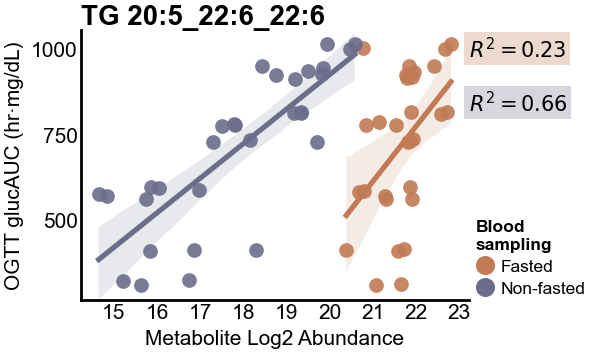

In [21]:
importlib.reload(src.plots)

src.plots.plot_ogtt_vs_quant('l_569', tick_locator=plt.MultipleLocator(1))

In [363]:
# def plot_ogtt_vs_quant(feature, 
#                        data=data,
#                        ax=None,
#                        legend=True,
#                        legend_loc=(1.01, 0),
#                        group_within_animal=False,
#                        alpha=0.9, 
#                        palette=colors,
#                        figsize=(2.5, 2),
#                        robust=False,
#                        scatter_kws=None,
#                        line_kws=dict(lw=1.5),
#                       ):
#     """
#     Swapped axes from `plot_quant_vs_ogtt`
#     """
#     if ax is None:
#         fig, ax = plt.subplots(dpi=250, figsize=figsize)
        
#     # Automatically include lw=0 to avoid the wrong-alpha edge color on scatter points
#     if scatter_kws is None:
#         scatter_kws = dict(lw=0)
#     elif 'lw' not in scatter_kws:
#         scatter_kws['lw'] = 0
#     scatter_kws['alpha'] = alpha
        
#     df = (data
#           .loc[feature, data_cols]
#           .T
#           .to_frame(name=feature)
#           .join(fg[['ogtt', 'animal']]))
#     for bg_type, bg_cols, loc in (['Fasted', fbg_cols, 0.9], ['Non-fasted', rbg_cols, 0.7]):
#         regdf = df.loc[bg_cols]
#         if group_within_animal:
#             regdf = regdf.groupby('animal').mean()
            
#         sns.regplot(
#             data=regdf, x=feature, y='ogtt', color=colors[bg_type], ax=ax,
#             y_jitter=1000,
#             scatter_kws=scatter_kws, line_kws=line_kws,
#         )
            
#         lr = linregress(regdf[feature], regdf['ogtt'])
#         r2 = round(lr.rvalue ** 2, 2)
        
#         ax.text(1, loc, f'$R^2 = {r2}$', fontsize=6, fontweight='bold', transform=ax.transAxes,
#                 bbox=dict(fc=colors[bg_type], alpha=0.28, pad=1.2, lw=0))
    
#     ax.set_title(row['ID'], fontweight='bold', loc='left', pad=0.5, fontsize=8)
#     ax.set_xlabel('Metabolite Log2 Abundance', fontsize=6)
#     ax.set_ylabel('OGTT glucAUC (mg/dL/min)', fontsize=6)
#     ax.set_yticks([20000, 40000, 60000], ['20k', '40k', '60k'])
#     ax.set_ylim(regdf['ogtt'].min() - 5000, regdf['ogtt'].max() + 5000)
#     ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
#     ax.tick_params(length=0, pad=TICK_PAD, labelsize=TICK_FONTSIZE)
    
#     if legend:
#         custom_legend(entries=['Fasted', 'Non-fasted'], ax=ax,
#             loc=legend_loc,
#             title='Blood\nsampling', fontsize=6, title_fontsize=6, ms=7)
#     sns.despine(ax=ax)

# Top 5 elastic net features OGTT vs Quant plots

Text(0.5, 0, 'Metabolite Log2 Abundance')

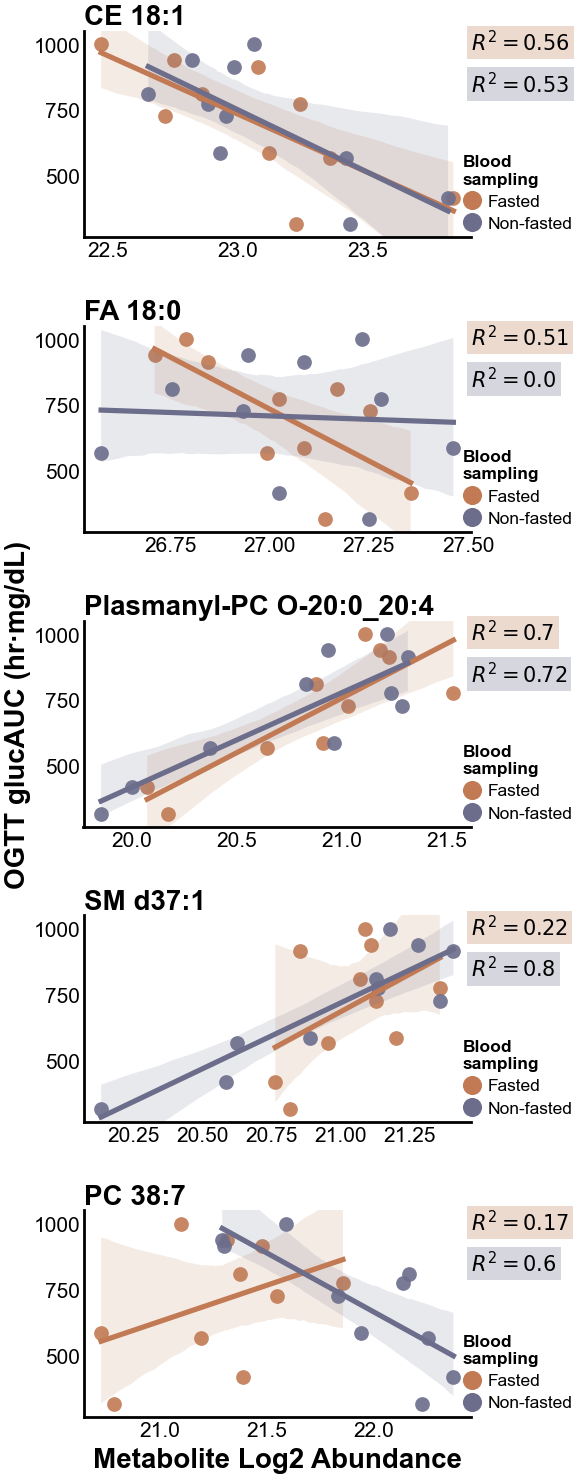

In [24]:
importlib.reload(src.plots)
nrows = 5
fig, axs = plt.subplots(nrows=5, figsize=(2, 1.2 + 1.2*nrows), dpi=250,
                        gridspec_kw=dict(hspace=0.43))
np.random.seed(1)
for i, (feature, row) in enumerate(hdf.iloc[:5].iterrows()):
    ax = axs[i]
    src.plots.plot_ogtt_vs_quant(feature, group_within_animal=True, ax=ax, legend_loc=(0.97, 0.01))
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.tick_params(axis='x', pad=1.5)
fig.supylabel(src.plots.ogtt_gluc_label, fontsize=8, fontweight='bold', ha='right')
axs[-1].set_xlabel('Metabolite Log2 Abundance', fontsize=8, fontweight='bold')
# plt.savefig('../reports/figures/Figure6/ogtt_vs_quant_top5_avg_within_animal.pdf', bbox_inches='tight', dpi=300)

# Top 5 elastic net features Quant vs OGTT plots

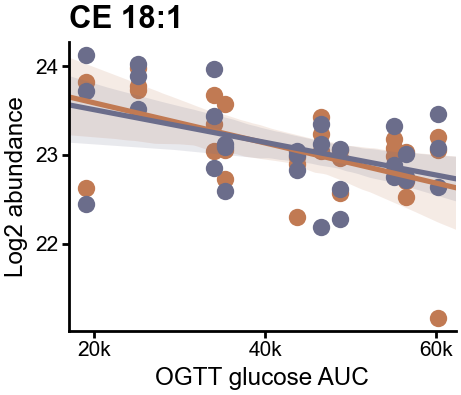

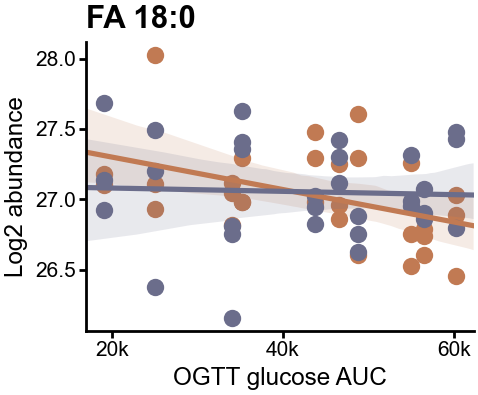

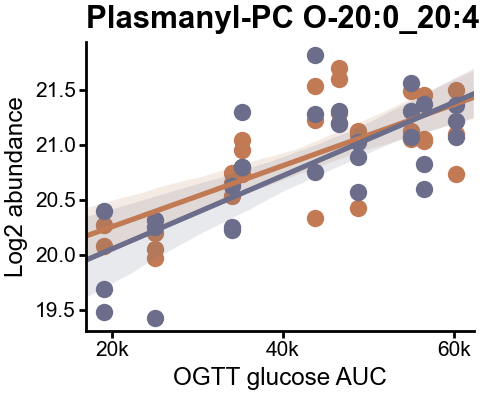

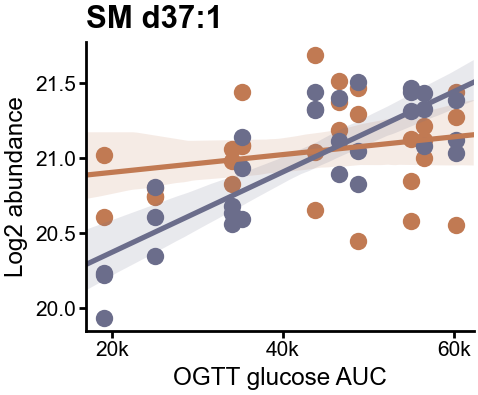

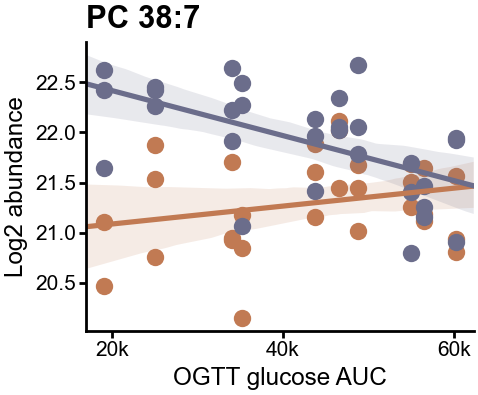

In [480]:
for i, row in hdf.iloc[:5].iterrows():
    src.plots.plot_quant_vs_ogtt(i, scatter_kws=dict(s=25))
    plt.gcf().set_size_inches(2, 1.5)
    plt.gca().set_title(row['ID'], loc='left', fontsize=9, fontweight='bold')
    plt.savefig(f'../reports/figures/Figure6/metab_quant_vs_ogtt_plots/{i}.pdf', bbox_inches='tight', dpi=300)

# What is the feature normalized importance of fasted versus non-fasted in elastic net model?

# Look at the straight lines of features radiating from origin!

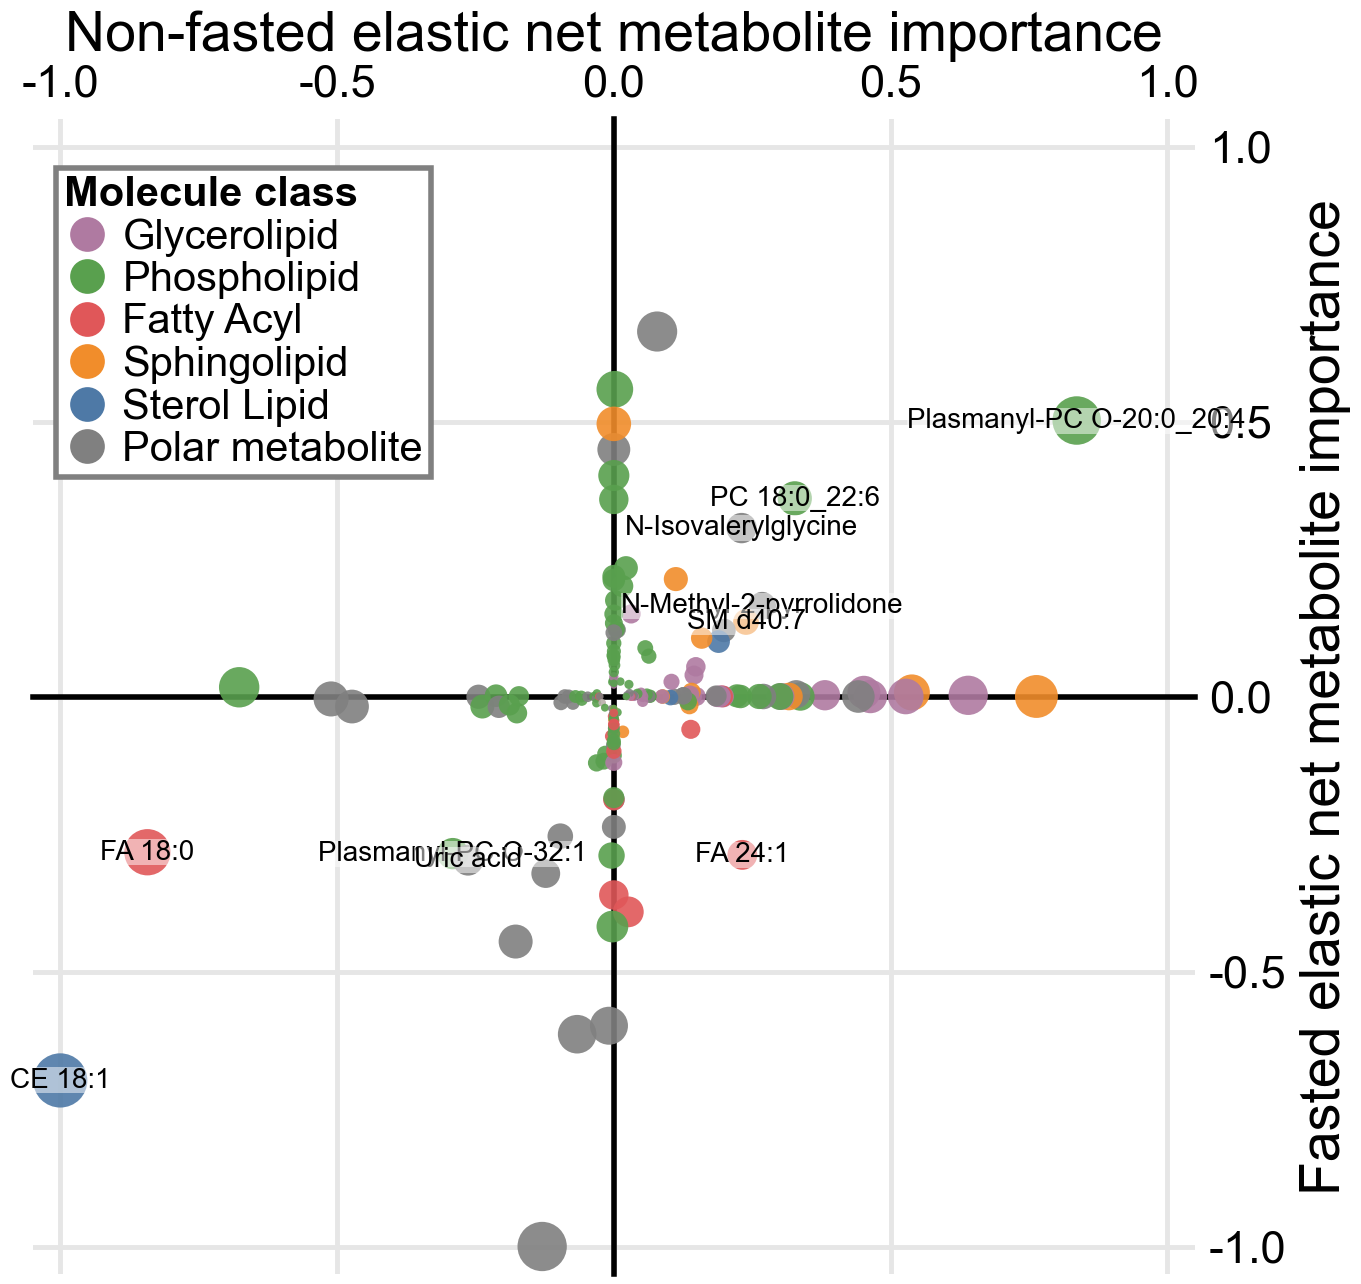

In [172]:
importlib.reload(src.plots)
coefdf = (r['en']['rbg']['coefs']
          .join(r['en']['fbg']['coefs'], lsuffix='_rbg', rsuffix='_fbg')
          .join(data[['superclass', 'Type', 'ID']]) 
         )
coefdf['fed_abs'] = coefdf['coef_rbg'].abs()
coefdf['fasted_abs'] = coefdf['coef_fbg'].abs()
coefdf['color'] = coefdf['superclass'].map(colors)
coefdf.loc[coefdf['Type'] == 'metabolite', 'color'] = '0.5'
def calc_size(fed, fasted):
    if max(fed, fasted) < 0.02:
        s = 3
    else:
        s = np.sqrt((fed**2 + fasted**2)) * 50
    return s
coefdf['s'] = coefdf[['fed_abs', 'fasted_abs']].apply(lambda x: calc_size(x[0], x[1]), axis=1)

# filter on min importance
min_imp = 0.02
coefdf = coefdf.loc[(coefdf['fed_abs'] > min_imp) | (coefdf['fasted_abs'] > min_imp)]

fig, ax = plt.subplots(figsize=(3, 3), dpi=500)
ax.scatter(data=coefdf, x='coef_rbg', y='coef_fbg', color='color', s='s', alpha=0.9, lw=0, zorder=10)
for i, row in coefdf.iterrows():  # Plot text 
    if row['s'] < 10:
        continue
    if row['fasted_abs'] < 0.1 or row['fed_abs'] < 0.2 or row['ID'] == 'Unidentified':
        continue
    id_text = row['ID']#.replace(' ', '\n')
    ax.text(row['coef_rbg'], row['coef_fbg'], id_text, ha='center', va='center', fontsize=4, 
            bbox=dict(fc='white', lw=0, pad=0, alpha=0.5), zorder=50)
# for radius in [0.5, 1.0]:
#     circle = plt.matplotlib.patches.Circle(xy=(0, 0), radius=radius, fc='none', lw=1, ec='0.8', zorder=-2)
#     ax.add_patch(circle)
ax.set(xlabel='Non-fasted elastic net metabolite importance', ylabel='Fasted elastic net metabolite importance',
       xlim=(-1.05, 1.05), ylim=(-1.05, 1.05))
ax.tick_params(length=0, pad=2, labelsize=6.5)
ax.spines.left.set_position('zero')
ax.yaxis.set_label_position('right')
ax.spines.bottom.set_position('zero')
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_ticks_position('right')
ax.set_axisbelow(True)
ax.grid(lw=0.7, color='0.9')

colors['Polar metabolite'] = '0.5'
src.plots.custom_legend(
    ax=ax, entries=src.plots.lipid_categories + ['Polar metabolite'], palette=colors, sort=False,
    title='Molecule class', mew=0, title_fontsize=6, fontsize=6, ms=5, loc=(0.02, 0.69), 
    show_frame=True, frame_color='white', frame_edgecolor='0.5', labelspacing=0.1, 
)
sns.despine()
plt.savefig('../reports/figures/FigureSupp/Fed_vs_fasted_elastic_net_importances.pdf', bbox_inches='tight', dpi=300)
# plt.savefig('../reports/figures/FigureSupp/Fed_vs_fasted_elastic_net_importances.png', bbox_inches='tight', dpi=500)

In [220]:
data.loc[data['ID'].str.contains('TG 20:5_22:6'), ['ID', 'qval_fed', 'qval_fasted', 'qval_sampling']]

,ID,qval_fed,qval_fasted,qval_sampling
i,,,,
l_569,TG 20:5_22:6_22:6,0.000002,0.057591,1.791776e-22


In [348]:
import plotly.express as px

In [352]:
px.scatter(coefdf, x='coef_rbg', y='coef_fbg', hover_name='ID')
           #color='color')
# px.sunburst

# Some metabolites have high average importances, but what if they only appear with other features? 
## Then they would likely have large variance in their importance

# Try assessing the variance of the importance across all features too 

# Conclusion:
1. standard deviations of importances across features is about the same for the top metabolites
2. The ordering of top ranked features is approximately the same regardless of CV split

In [204]:
ddf = data.loc[data['ID'] != 'Unidentified', data_cols]
features = ddf.index
ddf = ddf.T.join(fg[['ogtt']])

ddf

rkf = RepeatedKFold(n_splits=6, n_repeats=200)
gkf = GroupKFold(n_splits=3)

cvs = {}

for name, cols, cv_splits in [('nonfasted', rbg_cols, rbg_splits), 
                             ('fasted', fbg_cols, fbg_splits)]:
    cv = cross_validate(
        estimator=ElasticNet(alpha=1, l1_ratio=0.9),
#         estimator=LinearRegression(),
        X=X_id, y=y_ogtt,
        cv=cv_splits, scoring='r2',
        n_jobs=7, return_estimator=True,
    )
    cvs[name] = cv

In [205]:
print(np.median(cvs['nonfasted']['test_score']))
print(np.median(cvs['fasted']['test_score']))

0.13813818639026082
-0.23662155987202227


In [206]:
coefs = []
for estimator in cvs['nonfasted']['estimator']:
    coefs.append(estimator.coef_)
coefs = pd.DataFrame(coefs, columns=estimator.feature_names_in_)
desc = coefs.describe().T.join(data[['ID', 'superclass']])
desc['color'] = desc['superclass'].map(colors)
desc['abs_mean'] = desc['mean'].abs()
desc['rsd'] = desc['std']/desc['abs_mean']
desc = desc.sort_values('abs_mean', ascending=False)
desc.insert(0, 'rank', range(len(desc)))

In [203]:
# en_top10 = desc.iloc[:10].index

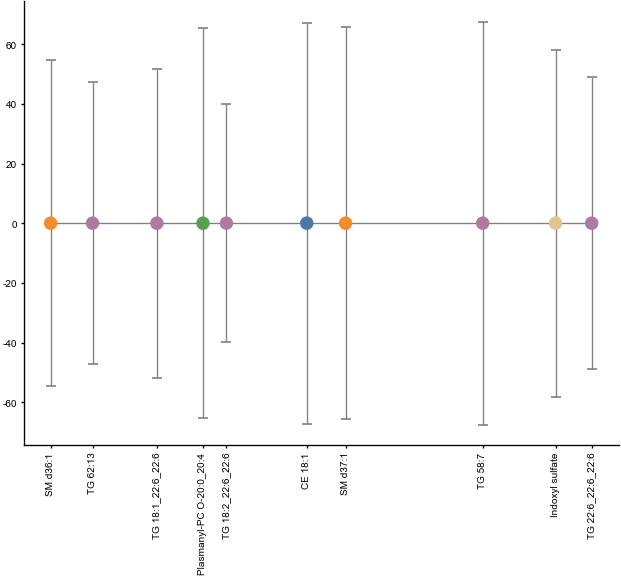

In [210]:
df = desc.loc[desc['abs_mean'] > 1]
plt.scatter('abs_mean', len(df)*[0], color='color', data=df, s=50)
plt.errorbar(x='abs_mean', y=len(df)*[0], yerr='std', data=df, zorder=-1, color='gray', 
             linewidth=0.8, capsize=3)
# plt.ylim(0, 25)
plt.xticks(ticks=df['abs_mean'], labels=df['ID'], rotation=90)
sns.despine()

# Try doing logistic regression

In [458]:
from yellowbrick.model_selection import LearningCurve, FeatureImportances

In [447]:


y_2class = (fg
            .loc[fg['original'], 'animal']
            .apply(lambda x: 'normal' if (x=='1091' or x == '1092' or x == '1093') else 'diabetic')
           )

logcv = sklearn.linear_model.LogisticRegressionCV(
    Cs=20,
    solver='saga',
    cv=custom_splits[0],
    penalty='elasticnet',
#     scoring=['r2', 'neg_mean_absolute_percentage_error'],
    l1_ratios=[0.2, 0.5, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.92, 0.95, 0.97, 0.99, 0.999],
    max_iter=10000,
    n_jobs=7,
)
fit = logcv.fit(X_id, y_2class.values)

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-p

In [457]:
FeatureImportances()

In [470]:
fit.scores_['normal'].shape

(200, 20, 13)

In [453]:
pd.DataFrame(fit.coef_, columns=X_id.columns).T.sort_values(0).join(data['ID'])

,0,ID
i,,
l_505,-0.437409,Plasmanyl-PC O-20:0_20:4
l_501,-0.339159,PC 35:0
m_88,-0.317491,Creatine
l_435,-0.313573,SM d37:1
l_298,-0.296642,Plasmenyl-PE P-18:1_22:6
...,...,...
l_417,0.278409,FA 25:0
m_138,0.285586,2-Naphthalenesulfonic acid
l_598,0.299156,Cer[NS] d18:1_24:0


## Corr vs. corr plot fasted vs. fed

In [458]:
cdf = (corrdf
       .loc[(data['ID'] != 'Unidentified') & 
            ((corrdf['rbg_p'] < 0.05) | (corrdf['fbg_p'] < 0.05)) 
           ]
       .join(data[['superclass', 'molec_class', 'ID', 'Type']]))

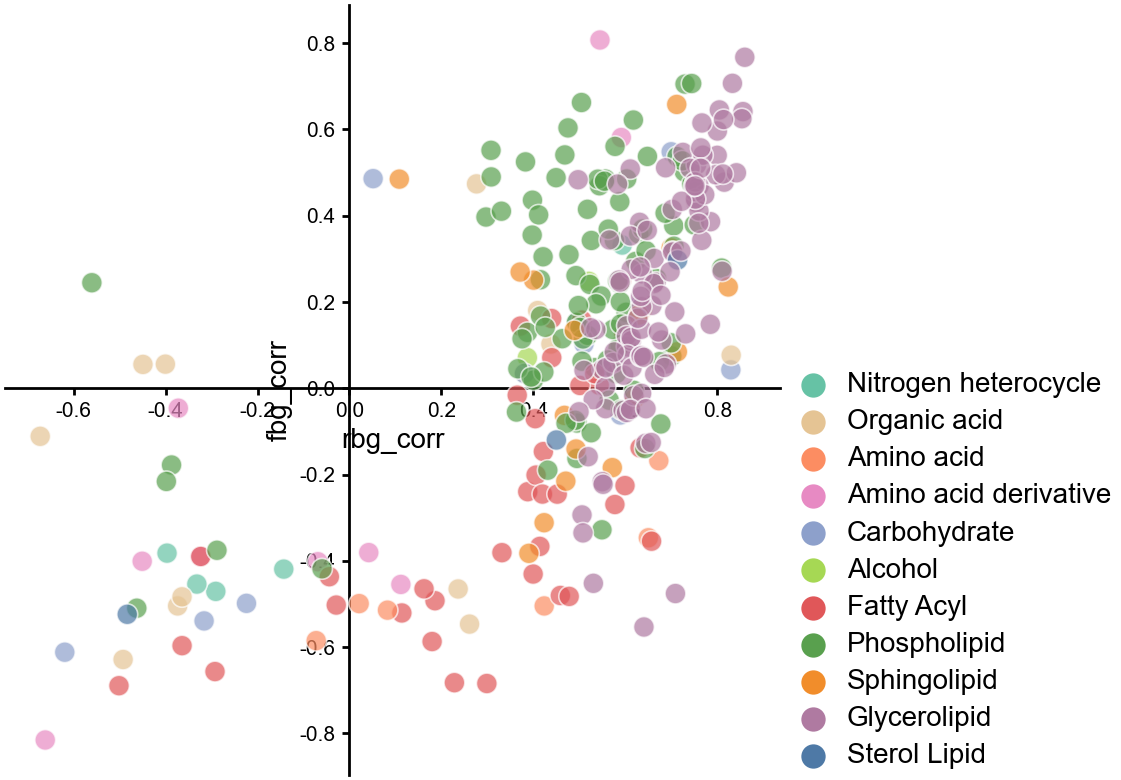

In [446]:

fig, ax = plt.subplots(dpi=250, figsize=(4,4))
sns.scatterplot(
    data=cdf, x='rbg_corr', y='fbg_corr', hue='superclass', palette=colors,
    alpha=0.7, zorder=10,
)
ax.spines.left.set_position('zero')
ax.spines.bottom.set_position('zero')
ax.set_axisbelow(True)

ax.legend(loc=(1, 0))
sns.despine()

In [454]:
cdf[['rbg_corr', 'fbg_corr']].abs().max().max()

0.8596641391476392

In [461]:
hcdf

,rbg_corr,rbg_p,fbg_corr,fbg_p,rbg_q,fbg_q,rbg_corr_signif,fbg_corr_signif,rbg_corr_sign,fbg_corr_sign,superclass,molec_class,ID,Type
i,,,,,,,,,,,,,,
l_0,-0.028754,0.880110,-0.502688,0.005450,0.917215,0.045434,False,True,ns,-,Fatty Acyl,AC,AC 5:0,lipid
l_1,-0.501352,0.004767,-0.689639,0.000035,0.012212,0.002053,True,True,-,-,Fatty Acyl,AC,AC 4:0,lipid
l_2,-0.323457,0.081231,-0.390004,0.036485,0.138565,0.149438,False,False,ns,ns,Fatty Acyl,AC,AC 3:0,lipid
l_3,-0.364120,0.047914,-0.596795,0.000632,0.089776,0.010429,False,True,ns,-,Fatty Acyl,AC,AC 2:0,lipid
l_4,0.113835,0.549201,-0.520991,0.003757,0.651916,0.035294,False,True,ns,-,Fatty Acyl,AC,AC 18:2,lipid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m_126,0.236328,0.208638,-0.465387,0.010958,0.300277,0.064334,False,False,ns,ns,Organic acid,Organic acid,4-Hydroxybutyric acid (GHB),metabolite
m_128,0.637446,0.000152,0.182277,0.343956,0.000744,0.591018,True,False,+,ns,Organic acid,Organic acid,4-Guanidinobutyric acid,metabolite
m_135,-0.449168,0.012776,0.055279,0.775790,0.028664,0.882688,True,False,-,ns,Organic acid,Organic acid,3-Indoxyl sulphate,metabolite


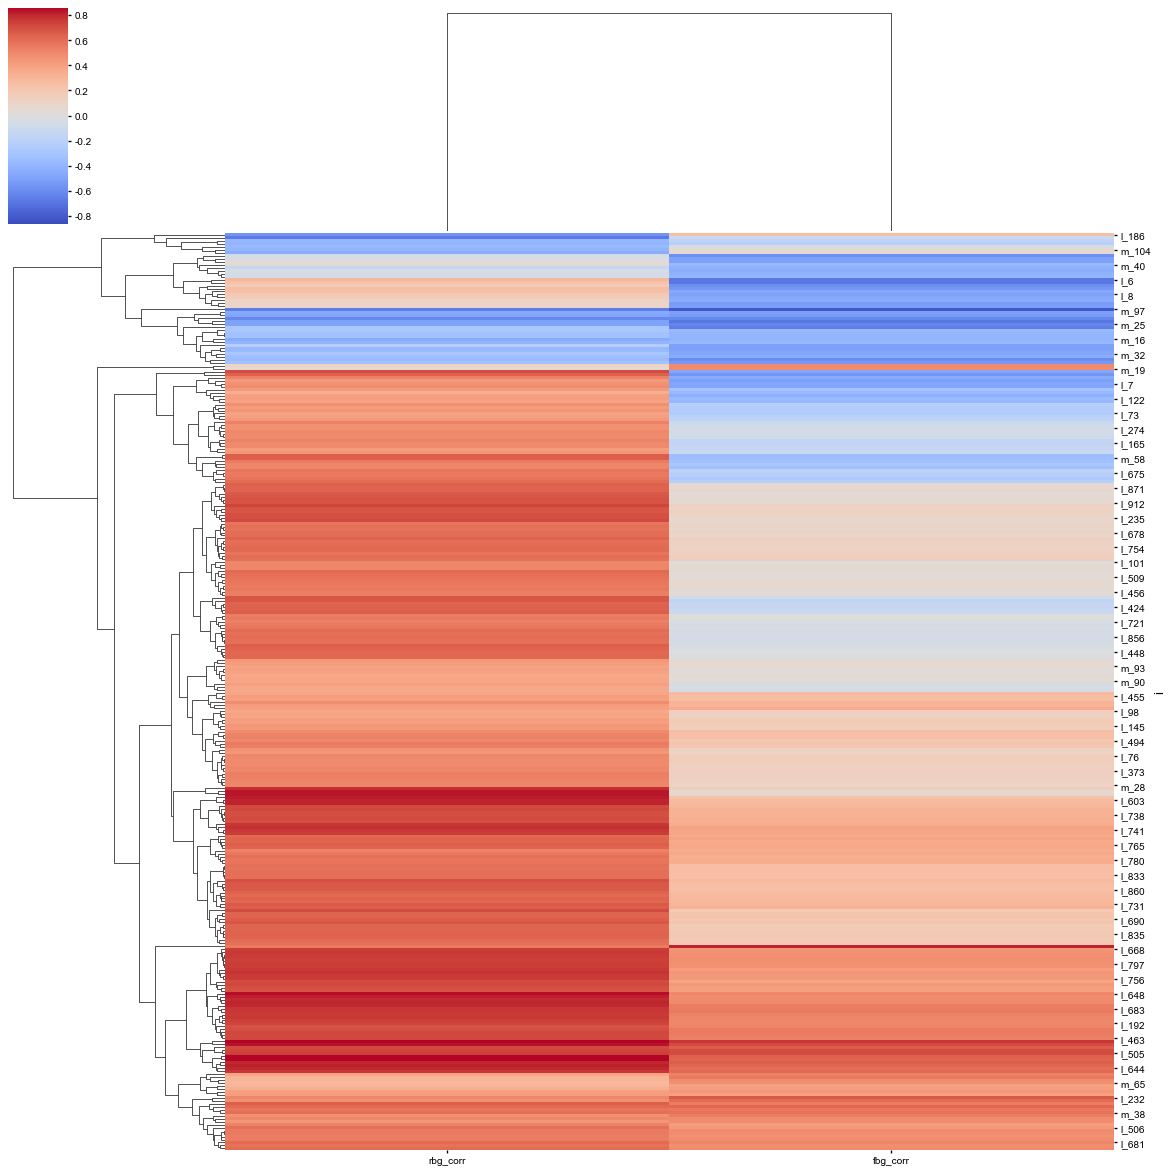

In [462]:
# fig, ax = plt.subplots(dpi=120, figsize=(2, 8))
max_corr = cdf[['rbg_corr', 'fbg_corr']].abs().max().max()
hcdf = cdf.sort_values(['Type', 'superclass'])
sns.clustermap(
    data=hcdf[['rbg_corr', 'fbg_corr']],
    vmin=-max_corr, vmax=max_corr, center=0, cmap='coolwarm',
)

# OLD CODE BELOW

## Process the model results file in one way for the boxplots

In [8]:
r = pd.read_csv(r'../data/interim/fasted_vs_fed_models/model_fasted_vs_fed_results.csv', 
                index_col=0).rename({'x': 'Sampling'}, axis=1)
r['Sampling'] = r['Sampling'].replace('Fed', 'Non-fasted')
# r['model'] = r['model'].map({'ols': 'OLS', 'lasso': 'LASSO (L1)', 'ridge': 'Ridge (L2)', 
#                                    'svm': 'SVM\nLinear kernel', 'pls': 'PLS', 'rf': 'Random\nForest'})
mse = r.melt(value_vars=r.filter(regex='neg_mean_squared_error_\d').columns, id_vars=['model', 'Sampling', 'y']) \
        .drop('variable', axis=1)
r2 = r.melt(value_vars=r.filter(regex='r2_\d').columns, id_vars=['model', 'Sampling', 'y']) \
        .drop('variable', axis=1)
mape = r.melt(value_vars=r.filter(regex='neg_mean_absolute_percentage_error_\d').columns, 
              id_vars=['model', 'Sampling', 'y']).drop('variable', axis=1)
mae = r.melt(value_vars=r.filter(regex='neg_mean_absolute_error_\d').columns, 
              id_vars=['model', 'Sampling', 'y']).drop('variable', axis=1)
ogtt = mse.loc[mse['y'] == 'ogtt'].drop('y', axis=1)
insulin = mse.loc[mse['y'] == 'insulin'].drop('y', axis=1)
weight = mse.loc[mse['y'] == 'weight'].drop('y', axis=1)

# Examples of other plots: catplot, stripplot, boxplot, boxenplot, histplot

## Boxplot overall looks good and will be good for `r2` with its crazy low outliers 

<AxesSubplot:xlabel='value', ylabel='model'>

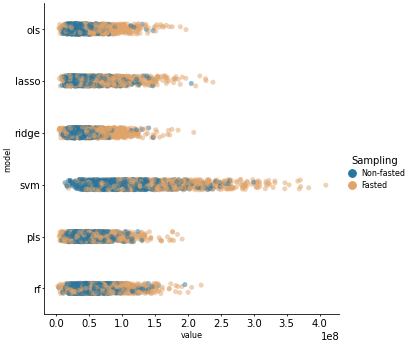

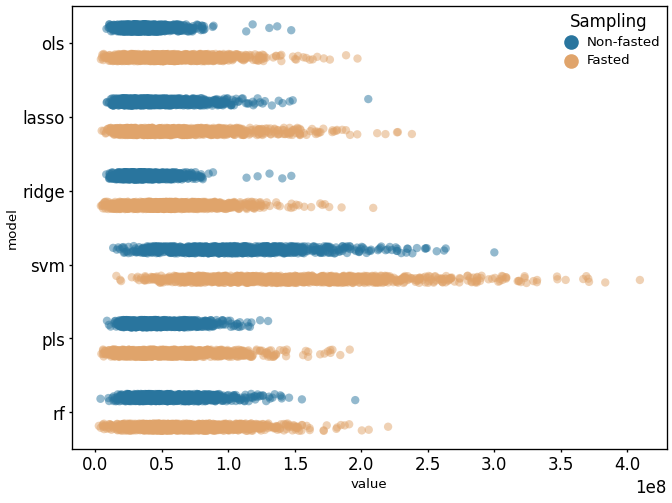

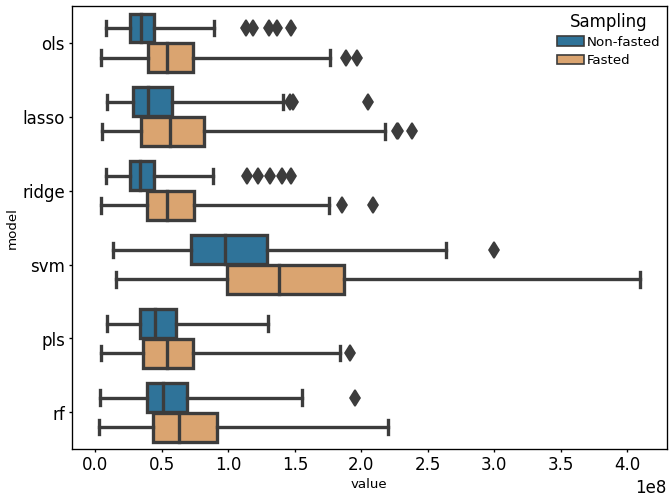

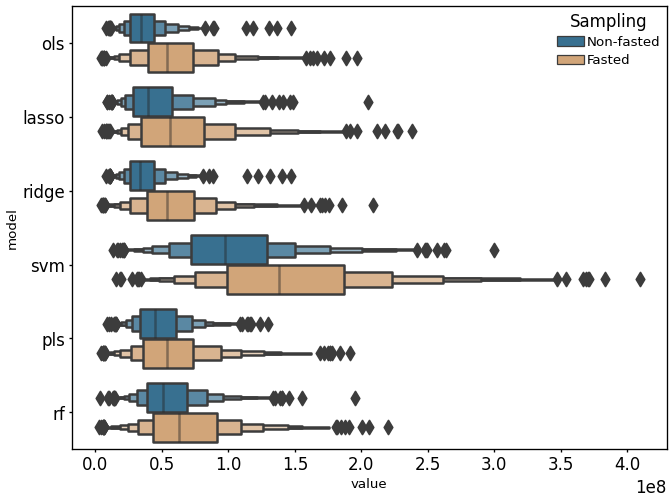

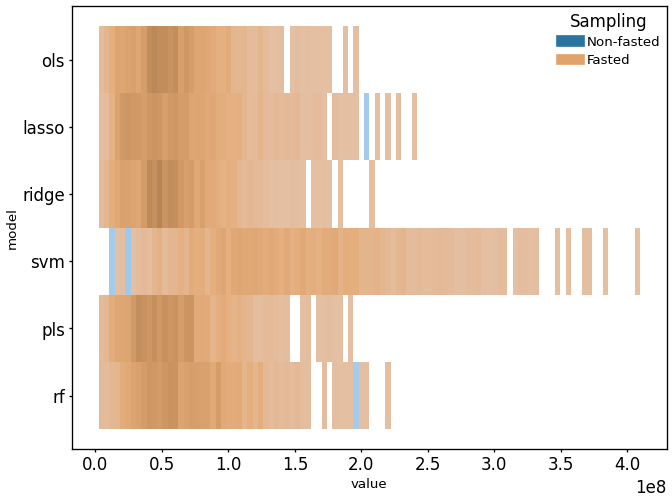

In [9]:
vp = sns.catplot(
    data=ogtt, x='value', y='model',
    orient='h', hue='Sampling',
#     dodge=True,
    palette=colors, alpha=0.5,)
plt.figure()
vp = sns.stripplot(
    data=ogtt, x='value', y='model',
    orient='h', hue='Sampling',
    dodge=True,
    palette=colors, alpha=0.5)
plt.figure()
vp = sns.boxplot(
    data=ogtt, x='value', y='model',
    orient='h', hue='Sampling',
    width=0.8,
    linewidth=2,
    fliersize=7, whis=3,
#     scale='width',
    palette=colors, saturation=0.9,)
plt.figure()
vp = sns.boxenplot(
    data=ogtt, x='value', y='model',
    orient='h', hue='Sampling',
#     scale='width',
    palette=colors, )
plt.figure()
sns.histplot(
    data=mse, x='value', y='model',
    hue='Sampling', palette=colors,)

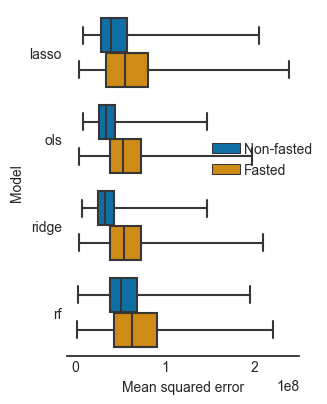

In [156]:
#### BOX PLOT VERSION ####

def plot_comparison(y, error, cut=0.4, width=0.65, whis=1.5, left=True,
                    order=['SVM\nLinear kernel', 'Random\nForest', 'PLS', 'LASSO (L1)', 'Ridge (L2)', 'OLS'],
                    annot_loc=0.35, sci_notation_format=True, round_decimal=2, split=True, ax=None,
                    loc=(0.6, 0.5),
                    **kwargs):
    df = r.loc[r['y'] == y]
    df = df.melt(value_vars=r.filter(regex=f'{error}_\d').columns, id_vars=['model', 'Sampling', 'y']) \
           .drop('variable', axis=1)
    if ax is None:
        fig, ax = plt.subplots(figsize=(3, 4.5))
    p = sns.boxplot(
        data=df, x='value', y='model', hue='Sampling', ax=ax,
        orient='h', fliersize=5, whis=whis, order=order,
#         scale='width', cut=cut, width=width,
        palette=colors, saturation=0.85,  **kwargs)
    
    for i, model in enumerate(r['model'].unique()):
        for bg_type, direction in [('Fasted', 1), ('Non-fasted', -1)]:
            error_median = r.loc[(r['model'] == model) & (r['Sampling'] == bg_type) & (r['y'] == y), 
                             f'{error}_median'].iloc[0]
            x_point = ax.get_xlim()[1] * annot_loc
            if sci_notation_format:
                error_median = f"{Decimal(error_median):.1e}".replace('+', '')
            else:
                error_median = round(error_median, round_decimal)
#             ax.annotate(error_median, xy=(annot_loc, i*(1/6)+direction*0.02), 
#                          ha='center', va='center', fontsize=14, xycoords='figure fraction')
#             ax.annotate(error_median, xy=(, i + direction*0.2), 
#                          ha='center', va='center', fontsize=14, xycoords='figure fraction')
#     plt.yticks(fontsize=14)
    ax.set_ylabel('Model', fontsize=10)
#     plt.xticks(fontsize=14)
    xlabel = error.lstrip('neg_').replace('_', ' ').capitalize()
    if xlabel == 'R2':
        xlabel = '$r^2$'
    ax.set_xlabel(xlabel, fontsize=10)
#     for y in np.arange(0.5, 5, 1):
#         plt.axhline(y=y, color='gray')
    ax.tick_params(axis='both', length=0)
#     plt.grid(axis='x', visible=None, ) 
    ax.set_axisbelow(True)  # puts grid behind the violins, because zorder doesn't work. 
    ax.legend(loc=loc, markerscale=3, fontsize=10, frameon=False, ncol=1, handletextpad=0.3)
    sns.despine(left=left)
    
plot_comparison(y='ogtt', split=False, annot_loc=0.5, whis=8, showfliers=True, left=True,
                order=['lasso', 'ols', 'ridge', 'rf'],
                error='neg_mean_squared_error',) # r2 neg_mean_absolute_percentage_error neg_mean_squared_error
                                                 
# plt.savefig(r'../reports/figures/fig6_model_feat_imp_plots/mse_boxplot.png', bbox_inches='tight', dpi=150)
# plt.savefig(r'../reports/figures/fig6_model_feat_imp_plots/mse_boxplot.pdf', bbox_inches='tight', dpi=150)

In [291]:
# plot_comparison(y='ogtt', split=False, annot_loc=0.5, left=False, showfliers=False, whis=1.5,
#                 error='r2')
# plt.savefig(r'../reports/figures/fasted_vs_fed_models/r2_boxplot.png', bbox_inches='tight', dpi=100)
# plt.savefig(r'../reports/figures/fasted_vs_fed_models/r2_boxplot.pdf', bbox_inches='tight', dpi=100)

## Process model results file in another way for the feature importance plots

In [6]:
rdf = pd.read_csv(r'../data/interim/fasted_vs_fed_models/model_fasted_vs_fed_results.csv', index_col=0)
rdf = rdf.loc[(rdf['y'] == 'ogtt') & 
              (rdf['model'].isin(['ols', 'lasso', 'pls', 'rf', 'svm', 'ridge']))].drop('y', axis=1)
cols = ['model', 'x']
cols.extend(data.index)
rdf = rdf[cols]
rdf['i'] = rdf['model'] + '_' + rdf['x']
new_cols = rdf['i']
rdf = rdf.drop(['model', 'x'], axis=1)
rdf = rdf.set_index('i').T.abs()
# rdf = rdf.loc[data['ID'] != 'unknown']  # only use IDs
# rdf = rdf.loc[(data['Type'] == 'lipid') & (data['ID'] != 'unknown')]
rdf.loc[:, :] = MinMaxScaler().fit_transform(rdf)  # perform 0 to 1 scaling of absolute value of coefficients
rdf = rdf.join(data)
rdf = rdf.sort_values('ols_Fed', ascending=False)  # .iloc[:20]
rdf['y_point'] = range(len(rdf))  # range(len(r), 0, -1)
rdf['is_id'] = rdf['ID'] != 'Unidentified'
rdf['avg_Fed'] = rdf.filter(regex='_Fed').mean(axis=1)
rdf['avg_Fasted'] = rdf.filter(regex='_Fasted').mean(axis=1)
rdf['Molecule class'] = rdf['superclass'].map(colors)
rdf['Molecule type'] = rdf['Type'].map(colors)
# rdf

## Using the normalized feature coefficients from the best performing model (Fed, linear regression), create a loadings plot of the features, colored by molec_class

In [255]:
odf = rdf[['ols_Fed']]
odf = odf.join(data[['ID', 'molec_class', 'superclass', 'Type']])
odf = odf.loc[odf['ID'] != 'Unidentified']

# re-normalize (because an Unidentified feature had the highest coefficient)
odf['ols_Fed'] = odf['ols_Fed'] / odf['ols_Fed'].max()
odf['i'] = odf.index
odf['color'] = odf['superclass'].map(colors)
mdf = odf.loc[odf['Type'] == 'metabolite']
odf = odf.loc[odf['Type'] == 'lipid']
# odf = odf.iloc[:100]
odf['rank'] = odf['ols_Fed'].rank(ascending=False)
odf

,ols_Fed,ID,molec_class,superclass,Type,i,color,rank
l_134,1.000000,FA 18:0,FA,Fatty Acyl,lipid,l_134,"[0.8392156862745098, 0.15294117647058825, 0.15...",1.0
l_435,0.908246,SM d37:1,SM,Sphingolipid,lipid,l_435,"[1.0, 0.4980392156862745, 0.054901960784313725]",2.0
l_844,0.858891,CE 18:1,CE,Sterol Lipid,lipid,l_844,"[0.12156862745098039, 0.4666666666666667, 0.70...",3.0
l_186,0.818057,PC 38:7,PC,Phospholipid,lipid,l_186,"[0.17254901960784313, 0.6274509803921569, 0.17...",4.0
l_505,0.817185,Plasmanyl-PC O-20:0_20:4,Plasmanyl-PC,Phospholipid,lipid,l_505,"[0.17254901960784313, 0.6274509803921569, 0.17...",5.0
...,...,...,...,...,...,...,...,...
l_173,0.007403,PI 18:2_18:1,PI,Phospholipid,lipid,l_173,"[0.17254901960784313, 0.6274509803921569, 0.17...",356.0
l_555,0.002729,Cer[NS] d18:1_24:1,Cer[NS],Sphingolipid,lipid,l_555,"[1.0, 0.4980392156862745, 0.054901960784313725]",357.0
l_576,0.001966,Cer[NS] d41:1,Cer[NS],Sphingolipid,lipid,l_576,"[1.0, 0.4980392156862745, 0.054901960784313725]",358.0
l_122,0.001670,FA 20:2,FA,Fatty Acyl,lipid,l_122,"[0.8392156862745098, 0.15294117647058825, 0.15...",359.0


In [261]:
# plt.hist(odf.loc[odf['molec_class'] == 'TG', 'rank'], bins=20)
# plt.figure()
# plt.hist(odf.loc[odf['superclass'] == 'Phospholipid', 'rank'], bins=20)

# The lipid "loadings" plot is surprisingly uniform in the distribution of Phospholipids vs TGs 

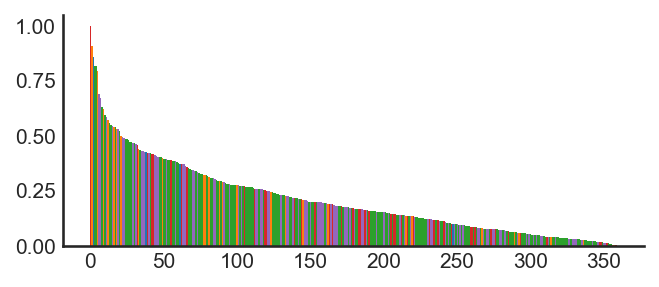

In [252]:
fig, ax = plt.subplots(dpi=150, figsize=(5, 2))
plt.bar(range(len(odf)), odf['ols_Fed'], color=odf['color'], edgecolor='none',
        width=1)
sns.despine()

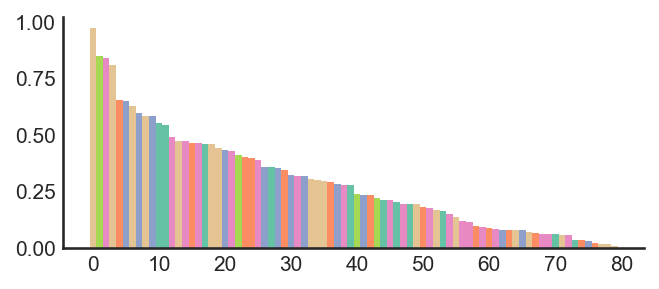

In [253]:
fig, ax = plt.subplots(dpi=150, figsize=(5, 2))
plt.bar(range(len(mdf)), mdf['ols_Fed'], color=mdf['color'], edgecolor='none',
        width=1)
sns.despine()

## Vertical orientation heatmap

In [38]:
data.loc[data['ID'].str.contains('22:6_22:6')]

,unique_id,ID,m/z,RT,molec_class,Type,polarity,lc_type,superclass,1091_8_FBG,...,log_qval_sampling,log_qval_ogtt,log_qval_sampling:ogtt,is_id,lipid_class,extra_lipid_label,fa_carbons,fa_unsat,fa_carbon:unsat,pval_asterisks
i,,,,,,,,,,,,,,,,,,,,,
l_569,TG 20:5_22:6_22:6_13.093_1014.755,TG 20:5_22:6_22:6,1014.75500,13.093,TG,lipid,+,RP,Glycerolipid,21.646018,...,21.746716,8.299210,3.393655,True,TG,NaN,64.0,17.0,64:17,***
l_582,TG 22:6_22:6_22:6_13.389_1040.7701,TG 22:6_22:6_22:6,1040.77014,13.389,TG,lipid,+,RP,Glycerolipid,20.194712,...,16.552043,12.085825,3.345257,True,TG,NaN,66.0,18.0,66:18,***
l_611,TG 18:2_22:6_22:6_14.115_997.7252,TG 18:2_22:6_22:6,997.72522,14.115,TG,lipid,+,RP,Glycerolipid,22.986681,...,12.528394,10.835321,3.444618,True,TG,NaN,62.0,14.0,62:14,***
l_648,TG 18:1_22:6_22:6_14.916_999.7401,TG 18:1_22:6_22:6,999.74011,14.916,TG,lipid,+,RP,Glycerolipid,22.408130,...,6.022581,8.799834,2.677907,True,TG,NaN,62.0,13.0,62:13,**
l_652,TG 16:0_22:6_22:6_14.93_973.725,TG 16:0_22:6_22:6,973.72504,14.930,TG,lipid,+,RP,Glycerolipid,23.106797,...,18.633607,8.849089,2.814134,True,TG,NaN,60.0,12.0,60:12,**


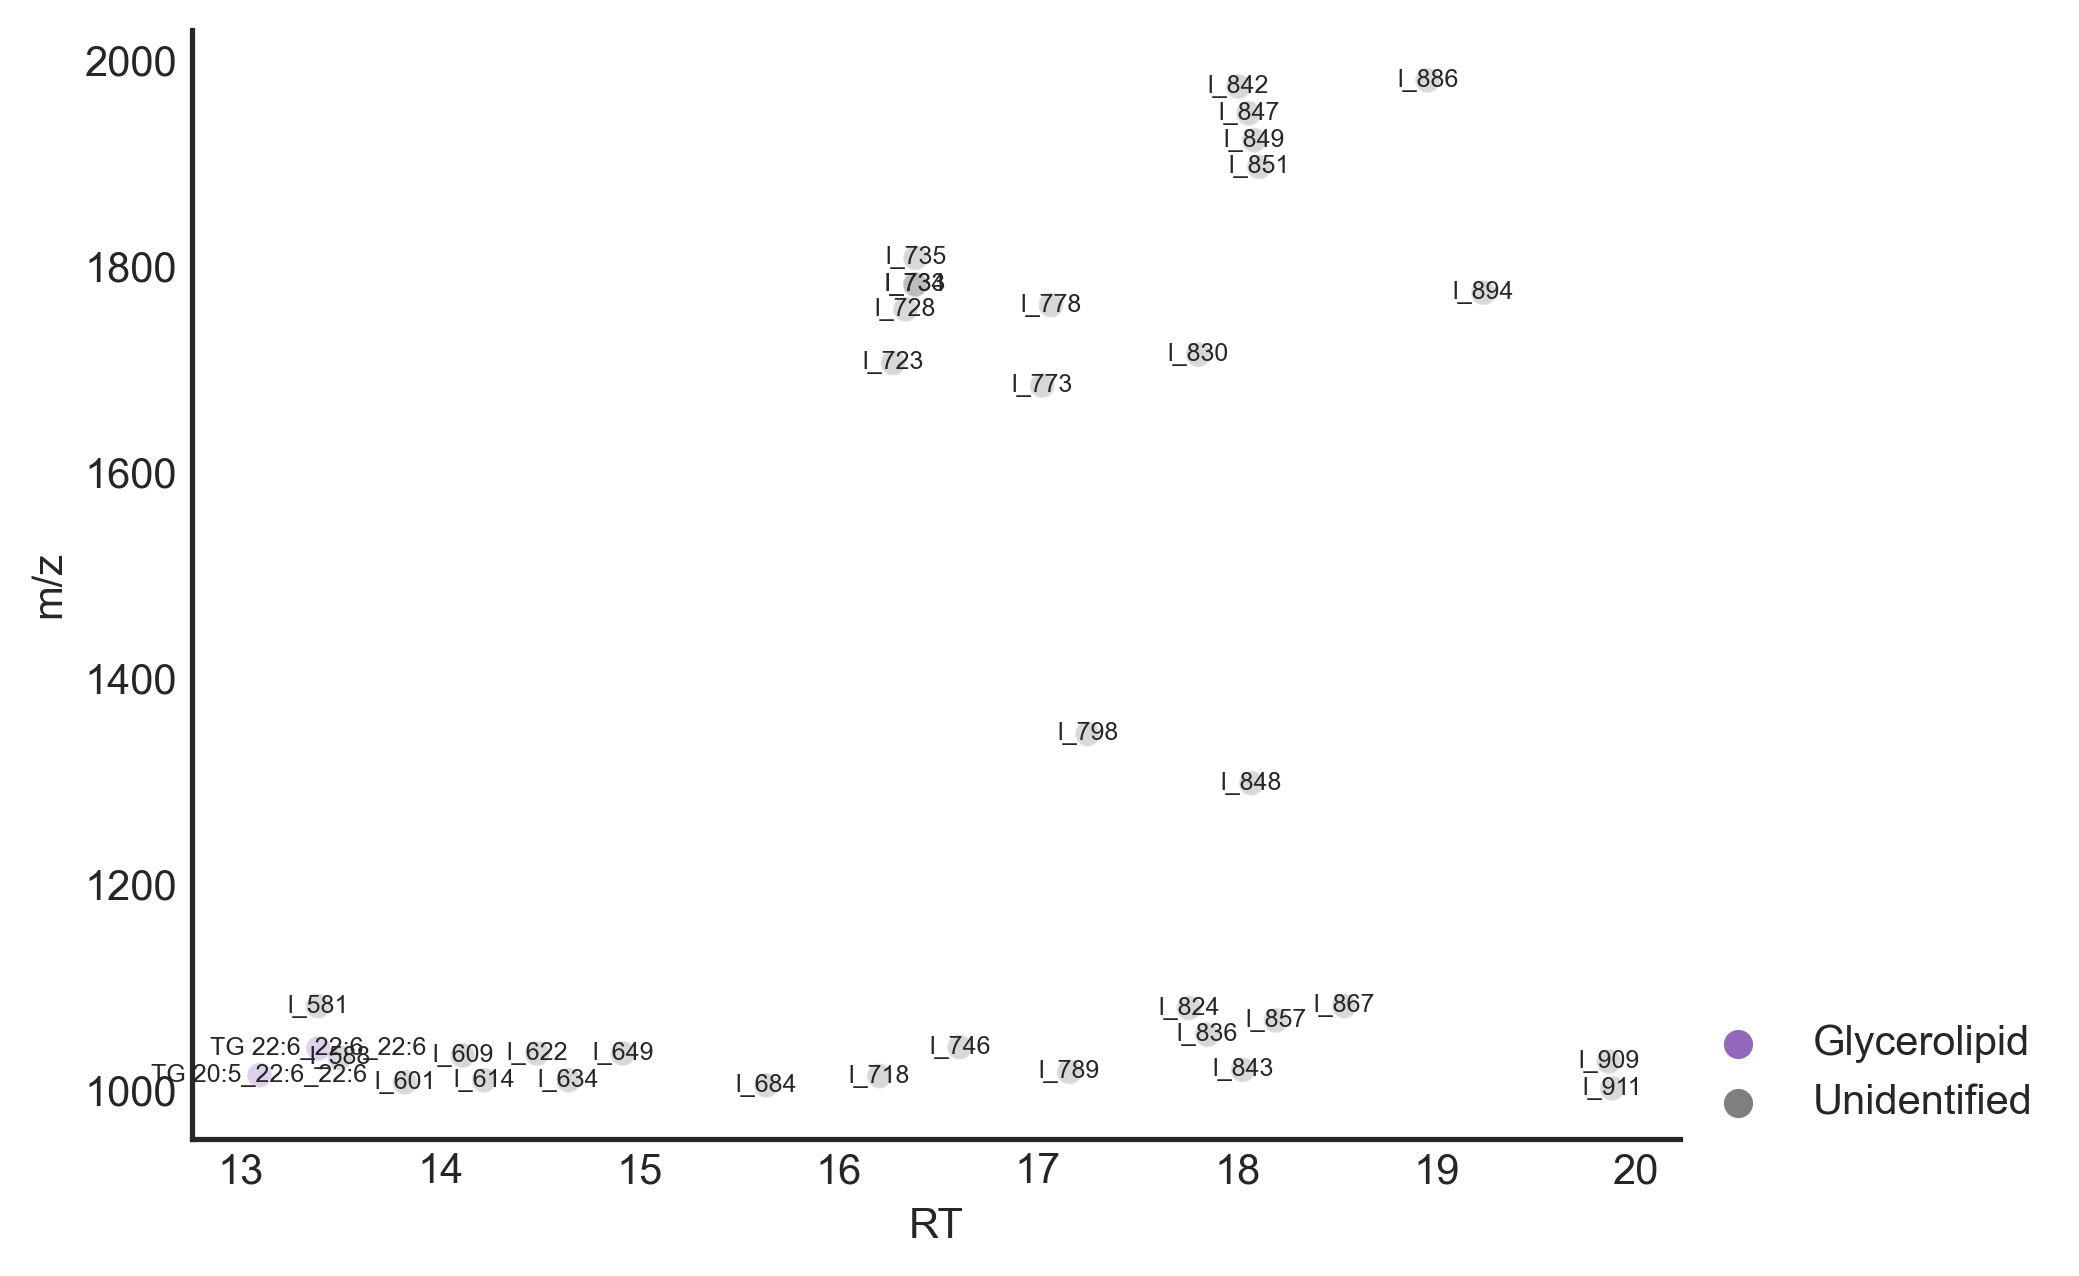

In [61]:
plotdf = data.loc[(data['RT'] > 13) & (data['m/z'] > 1000)]
fig, ax = plt.subplots(dpi=300)
sns.scatterplot(
    data=plotdf, ax=ax,
    x='RT', y='m/z', hue='superclass', palette=colors,
    alpha=0.3,
)
for i, row in plotdf.iterrows():
    if row['ID'] == 'Unidentified':
        text = i
    else:
        text = row['ID']
    ax.annotate(text=text, xy=(row['RT'], row['m/z']), ha='center', va='center', fontsize=6)
plt.legend(loc=(1, 0))
sns.despine()

<AxesSubplot:xlabel='ogtt', ylabel='quant'>

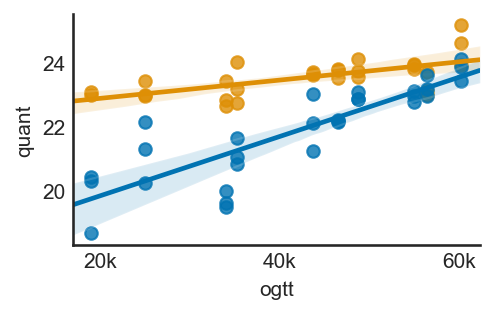

In [112]:
fig, ax = plt.subplots(figsize=(3.5, 2), dpi=150)
plot_quant_vs_ogtt('l_611', ax=ax)

In [67]:
rdf.sort_values('avg_Fed', ascending=False).loc[:, ['avg_Fed', 'ID', 'm/z', 'RT', 'polarity']].iloc[:30]

,avg_Fed,ID,m/z,RT,polarity
l_851,0.796973,Unidentified,1896.74500,18.110,+
l_435,0.756320,SM d37:1,745.62457,9.972,+
m_206,0.648419,Unidentified,223.08152,9.053,-
l_842,0.600881,Unidentified,1974.79395,18.006,+
l_581,0.591890,Unidentified,1081.79688,13.387,+
m_168,0.575684,Unidentified,174.00102,9.940,-
m_425,0.572947,Unidentified,261.21722,7.348,+
l_610,0.568701,Unidentified,994.77686,14.113,+
l_812,0.566652,Unidentified,383.36713,17.480,+
l_505,0.564724,Plasmanyl-PC O-20:0_20:4,824.65430,11.065,+


In [120]:
indexes = set()
for model in ['ols', 'pls', 'rf']:
    topdf = (rdf
             .loc[(data['ID'] != 'Unidentified') & (data['Type'])]
             .drop(['m_104', 'm_135'])
             .sort_values(by=f'{model}_Fed', ascending=False)
             
             .iloc[:10])
    display(topdf[[f'{model}_Fed', 'ID']])
    for i in topdf.index:
        indexes.add(i)
len(indexes)

,ols_Fed,ID
l_134,0.860758,FA 18:0
l_435,0.781780,SM d37:1
l_844,0.739298,CE 18:1
m_127,0.731062,4-Hydroxybenzaldehyde
m_34,0.720720,"N6,N6,N6-Trimethyl-L-lysine"
l_186,0.704149,PC 38:7
l_505,0.703398,Plasmanyl-PC O-20:0_20:4
l_195,0.682813,SM d36:3
l_794,0.591683,TG 58:7
l_648,0.578757,TG 18:1_22:6_22:6


,pls_Fed,ID
l_844,0.959198,CE 18:1
m_95,0.888387,Carnitine
l_435,0.849229,SM d37:1
l_186,0.794146,PC 38:7
l_195,0.764691,SM d36:3
l_496,0.758458,Plasmenyl-PE P-20:0_22:6
m_66,0.740813,Iditol
l_166,0.739526,SM d40:7
l_648,0.717220,TG 18:1_22:6_22:6
l_582,0.714897,TG 22:6_22:6_22:6


,rf_Fed,ID
l_648,0.258309,TG 18:1_22:6_22:6
l_569,0.254778,TG 20:5_22:6_22:6
l_663,0.254166,TG 16:0_22:6_22:5
l_582,0.243338,TG 22:6_22:6_22:6
l_623,0.243201,TG 62:13
l_123,0.215973,FA 24:5
l_435,0.214639,SM d37:1
l_330,0.200463,PC 39:4
l_632,0.175693,TG 18:1_20:5_22:6
l_611,0.168411,TG 18:2_22:6_22:6


22

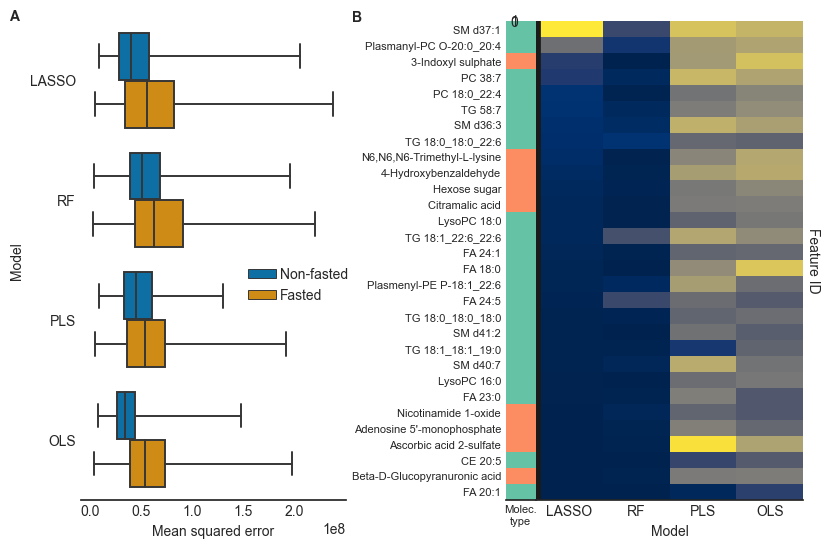

In [139]:
# fig, ax = plt.subplots(figsize=(3, 6), dpi=120)
Type = 'Fed'
models = [
    'lasso', 
    'rf',
    'pls', 
    'ols'
]
model_names = [model.upper() for model in models]
hmdf = (rdf
 .loc[
     (rdf['ID'] != 'Unidentified') 
#       & (rdf['Type'] == 'metabolite')
      , 
      [model + f'_{Type}' for model in models]]
 .sort_values(f'lasso_{Type}', ascending=False)
 .iloc[:30]
)

cm = sns.clustermap(
    hmdf, cmap='cividis',  # crest_r viridis  “magma”, “plasma”, “inferno”, “civids”, “mako”, and “rocket”
    row_cluster=False, col_cluster=False, row_colors=rdf.loc[hmdf.index, 'Molecule type'],
    colors_ratio=0.1, dendrogram_ratio=0.001, figsize=(8, 6), vmin=0, vmax=1,
#     cbar_pos=None,
    cbar_pos=(2, 0.4, 0.08, 0.4),  # (left, bottom, width, height)
#     cbar_kws={'aspect': 10},
)
hm = cm.ax_heatmap
rc = cm.ax_row_colors
cb = cm.ax_cbar

rc.set_yticks(ticks=np.arange(0.5, len(hmdf)+0.5, 1), labels=rdf.loc[hmdf.index, 'ID'], fontsize=8)
rc.set_xticklabels(labels=['Molec.\ntype'], fontsize=8, rotation=0)
hm.set_xlabel('Model')
hm.set_ylabel('Feature ID\n', rotation=270, labelpad=12)
hm.yaxis.set_label_position('right')
hm.set_yticks([])
# hm.tick_params(size=0, axis='x', pad=0.5)
hm.set_xticklabels(model_names, rotation=0)
hm.axvline(0, color='0.1', linewidth=7,)
# cb.set_title('Relative\nfeature\nimportance')

# labels = ['Lipid', 'Polar metabolite']
# handles = [Patch(facecolor=colors['lipid'], edgecolor='lightgray'), 
#            Patch(facecolor=colors['metabolite'], edgecolor='lightgray')]
# legend2 = plt.legend(handles, labels, title='Molecule type', 
#            bbox_to_anchor=(0.85, 0.2), bbox_transform=cm.fig.transFigure, loc=(0.5, 0.5))
# cm.fig.add_artist(legend2)

# Add models plot  # https://stackoverflow.com/questions/51811972/adding-seaborn-clustermap-to-figure-with-other-plots
cm.gs.update(left=0.55)
gs2 = plt.GridSpec(1, 1, right=0.35)
# gs3 = plt.GridSpec(1, 1, left=0.96)
ax2 = cm.fig.add_subplot(gs2[0])
# cax = cm.fig.add_subplot(gs3[0])
plot_comparison(y='ogtt', split=False, annot_loc=0.5, whis=8, showfliers=True, left=True, ax=ax2,
                order=models, loc=(0.61, 0.4), error='neg_mean_squared_error',)
ax2.set_yticklabels([model.upper() for model in models])
for ax, letter in zip([ax2, rc], ['A', 'B']):
        bb = tight_bbox(ax)
        ax.text(x=bb.x0, y=bb.y1, s=letter, transform=cm.fig.transFigure, fontweight='bold')
# print(rdf.loc[hmdf.index, 'ID'].value_counts())
# plt.savefig('../reports/figures/fig6_model_feat_imp_plots/combined.pdf', dpi=150, bbox_inches='tight', facecolor='white')
# plt.savefig('../reports/figures/fig6_model_feat_imp_plots/combined.png', dpi=150, bbox_inches='tight', facecolor='white')

''

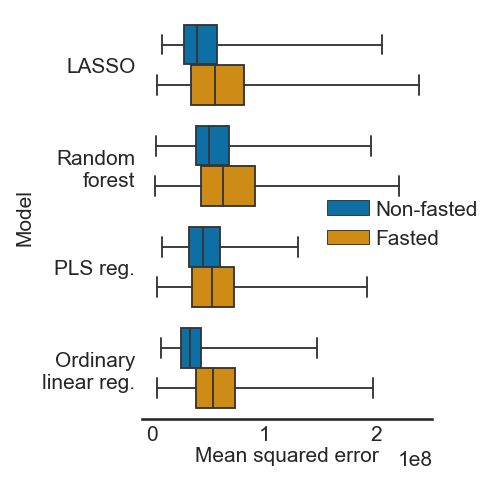

In [164]:
fig, ax = plt.subplots(figsize=(2.5, 3.5), dpi=150)
plot_comparison(y='ogtt', split=False, annot_loc=0.5, whis=8, showfliers=True, left=True, ax=ax,
                order=models, loc=(0.61, 0.4), error='neg_mean_squared_error',
                linewidth=0.9)
ax.set_yticks([0,1,2,3], ['LASSO', 'Random\nforest', 'PLS reg.', 'Ordinary\nlinear reg.'])
ax.tick_params(pad=3)
ax.set_xlabel('Mean squared error', labelpad=1)
;

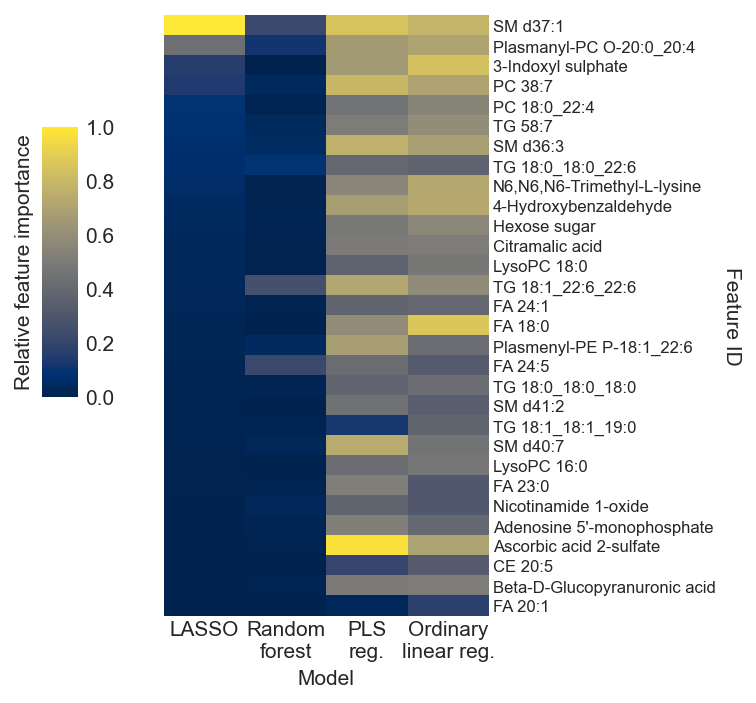

In [216]:
Type = 'Fed'
models = [
    'lasso', 
    'rf',
    'pls', 
    'ols'
]
model_names = [model.upper() for model in models]
long_model_names = ['LASSO', 'Random\nforest', 'PLS\nreg.', 'Ordinary\nlinear reg.']
hmdf = (rdf
 .loc[
     (rdf['ID'] != 'Unidentified') 
#       & (rdf['Type'] == 'metabolite')
      , 
      [model + f'_{Type}' for model in models]]
 .sort_values(f'lasso_{Type}', ascending=False)
 .iloc[:30]
)

cm = sns.clustermap(
    hmdf, cmap='cividis',  # crest_r viridis  “magma”, “plasma”, “inferno”, “civids”, “mako”, and “rocket”
    row_cluster=False, col_cluster=False, 
#     row_colors=rdf.loc[hmdf.index, 'Molecule type'], colors_ratio=0.1,
    dendrogram_ratio=0.001, figsize=(3, 4.5), vmin=0, vmax=1,
#     cbar_pos=None,
    cbar_pos=(-0.2, 0.4, 0.08, 0.4),  # (left, bottom, width, height)
#     cbar_kws={'label': 'hi'},
)
fig = cm.fig
hm = cm.ax_heatmap
cb = cm.ax_cbar
cb.yaxis.set_label_position('left')
cb.set_ylabel('Relative feature importance')
hm.set_yticks(ticks=np.arange(0.5, len(hmdf)+0.5, 1), labels=rdf.loc[hmdf.index, 'ID'], fontsize=8)
hm.tick_params(pad=2)
hm.set_xlabel('Model')
hm.set_ylabel('Feature ID\n', rotation=270, labelpad=12)
hm.yaxis.set_label_position('right')
hm.set_xticklabels(long_model_names, rotation=0)
fig.set_dpi(150)

In [223]:
def plot_importance(df, Type, sampling, is_id=True, num_features=20, 
                    model_ranking='ols', models=['ols', 'lasso', 'pls', 'rf'],
                    stem=False):
    """
    Type = 'lipid', 'metabolite' or '' empty string to get all 
    sampling = 'Fed' or 'Fasted'
    is_id = True for only IDs, False for only un-IDs, 
    """
    df = (df.loc[(df['is_id'] == is_id) & (df['Type'].str.contains(Type))] 
          .sort_values(f'{model_ranking}_{sampling}', ascending=False) 
          .iloc[:num_features] 
          .melt(id_vars=['ID'], value_vars=[model+'_'+sampling for model in models]) 
         )
    fig, ax = plt.subplots(figsize=(4, 1.6 + 0.4*num_features), dpi=80)
    bp = sns.barplot(
        data=df, x='value', y='ID', orient='horizontal', hue='variable',
        palette=sns.color_palette('cubehelix', len(models)),  # 'Set2' 'cubehelix', 'hls', 'husl', 'Dark2', 'brg'
        edgecolor='0.2', alpha=1, saturation=0.9, ci=None, dodge=True, ax=ax,
    )
    for patch in bp.patches:  # Set bar width, because the 'width' parameter in sns.barplot is broken 
        if stem:
            patch.set_height(0.08)
            patch.set_linewidth(0)
            bb = patch.get_bbox()
            ax.scatter([bb.x1], [bb.y1-0.05], color=patch.get_facecolor(), s=55)
        if not stem:
            patch.set_height(0.16)
        
    plt.yticks(fontsize=15)
    plt.ylabel('Identification', fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlabel('Scaled feature importance', fontsize=15)
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles=handles, labels=[x.upper() for x in models], 
               title='Model', title_fontsize=16, 
               loc=(1.01, 0.3), fontsize=14, markerscale=2)
    # plt.axvline(1, c='gray', alpha=0.7)
#     plt.grid(axis='x', visible=None)
#     for y_pos in np.arange(ax.get_ylim()[1], ax.get_ylim()[0], len(df)):
#         ax.axhspan(y_pos)
    sns.despine(left=True)
    return bp

(9.5, -1.0)

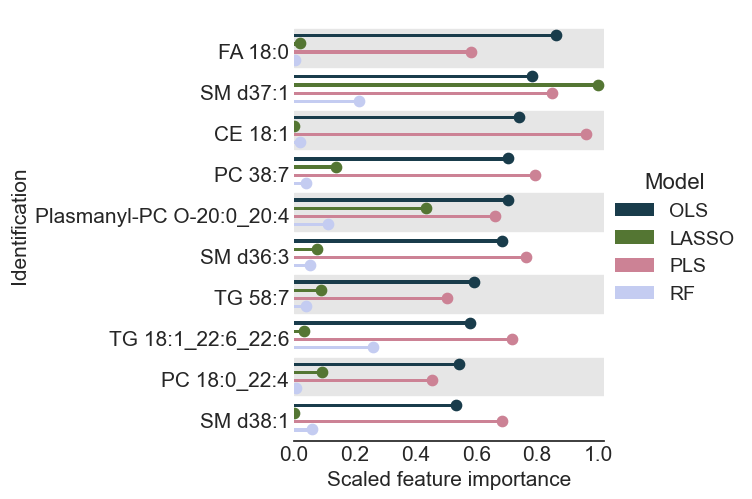

In [224]:
bp = plot_importance(df=rdf, Type='lipid', is_id=True, sampling='Fed', 
                     num_features=10, model_ranking='ols', stem=True)
fig = plt.gcf()
ax = plt.gca()
fig.set_facecolor('white')
fig.set_dpi(100)

for y_loc in ax.get_yticks()[::2]:
#     if y_loc % 2 == 1:
    ax.axhspan(ymin=y_loc-0.52, ymax=y_loc+0.4, color='0.9', zorder=-100)
ax.set_xlim(0, 1.02)
ax.set_ylim(9.5, -1)

## Horizontal heatmap orientation

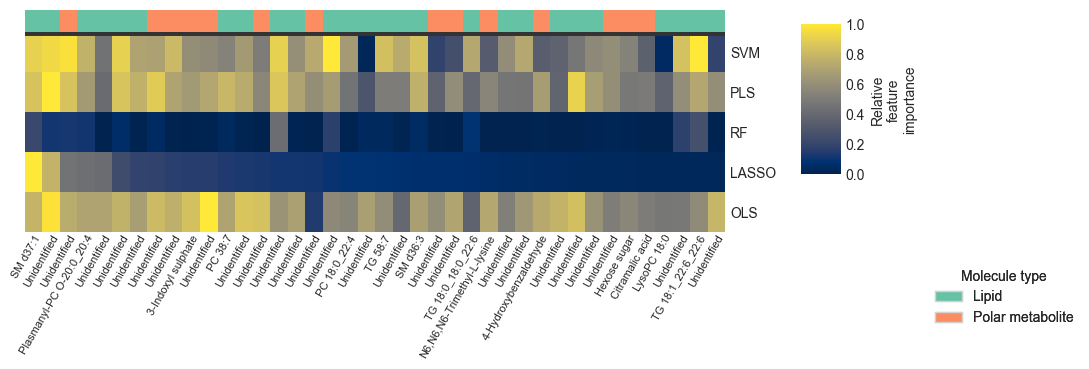

In [313]:
# fig, ax = plt.subplots(figsize=(3, 6), dpi=120)
Type = 'Fed'
models =      [ 'svm','pls', 'rf', 'lasso',  'ols',]
model_names = [ 'SVM','PLS', 'RF', 'LASSO',  'OLS',]
hmdf = (rdf
 .loc[:
#      (rdf['ID'] != 'Unidentified') 
#       & (rdf['Type'] == 'metabolite')
      , 
      [model + f'_{Type}' for model in models]]
 .sort_values(f'lasso_{Type}', ascending=False)
 .iloc[:40]
)

cm = sns.clustermap(
    hmdf.T, 
    cmap='cividis',  # crest_r viridis  “magma”, “plasma”, “inferno”, “civids”, “mako”, and “rocket”
    row_cluster=False, col_cluster=False,
    col_colors=(
        rdf.loc[hmdf.index, 'Molecule type'], 
#         rdf.loc[hmdf.index, 'Molecule class']
    ),
    colors_ratio=0.1, dendrogram_ratio=0.001,
    figsize=(8, 3),
    cbar_pos=(0.99, 0.4, 0.05, 0.5),  # (left, bottom, width, height)
    cbar_kws={'label': 'Relative\nfeature\nimportance'},
    vmin=0, vmax=1,
#     xticklabels=False,
#     legend=True,
)
hm = cm.ax_heatmap
hm.set_xticks(ticks=np.arange(1, len(hmdf)+1, 1), labels=rdf.loc[hmdf.index, 'ID'], 
              fontsize=8, rotation=60, ha='right', va='top');
hm.tick_params(size=0, axis='x', pad=0.5)
hm.set_yticklabels(model_names)
hm.axhline(0, color='0.2', linewidth=5,)
# cm.ax_col_colors.set_yticks([0.5, 1.5], ['Molecule type', 'Molecule class'])
cm.ax_col_colors.yaxis.tick_right()

# ADD LEGENDS TO PLOT
# handles, labels = [], []
# for superclass in rdf.loc[hmdf.index].sort_values('Type').loc[:, 'superclass'].unique():
#     s_color = colors[superclass]
#     labels.append(superclass)
#     handles.append(Patch(edgecolor='lightgray', facecolor=s_color))
# legend1 = plt.legend(handles, labels, title='Molecule class',
#            bbox_to_anchor=(1.2, 0.1), bbox_transform=cm.fig.transFigure, loc=(0.5, 0.5))
# cm.fig.add_artist(legend1)

labels = ['Lipid', 'Polar metabolite']
handles = [Patch(facecolor=colors['lipid'], edgecolor='lightgray'), 
           Patch(facecolor=colors['metabolite'], edgecolor='lightgray')]
legend2 = plt.legend(handles, labels, title='Molecule type', 
           bbox_to_anchor=(1.15, -0.12), bbox_transform=cm.fig.transFigure, loc=(0.5, 0.5))
cm.fig.add_artist(legend2)

# plt.savefig('../reports/figures/fig6_model_feat_imp_plots/Nonfasted_heatmap.pdf', dpi=150, bbox_inches='tight')
# plt.savefig('../reports/figures/fig6_model_feat_imp_plots/Nonfasted_heatmap.png', dpi=150, bbox_inches='tight')

In [ ]:
plt.colorbar

In [233]:
sns.heatmap

<function seaborn.matrix.heatmap(data, *, vmin=None, vmax=None, cmap=None, center=None, robust=False, annot=None, fmt='.2g', annot_kws=None, linewidths=0, linecolor='white', cbar=True, cbar_kws=None, cbar_ax=None, square=False, xticklabels='auto', yticklabels='auto', mask=None, ax=None, **kwargs)>

# Older versions below

(0.0, 1.0)

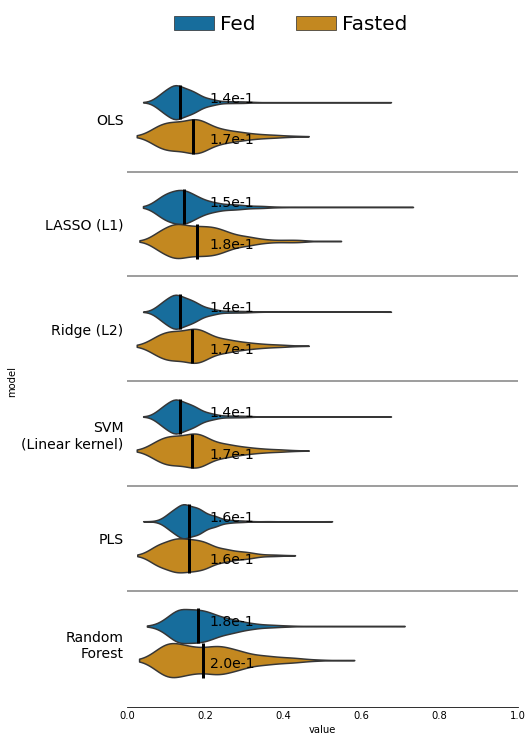

In [235]:
#### VIOLIN PLOT VERSION ####

def plot_comparison(y, error, cut=0.4, width=0.65, 
                    annot_loc=0.35, sci_notation_format=True, round_decimal=2, split=True, 
                    **kwargs):
    df = r.loc[r['y'] == y]
    df = df.melt(value_vars=r.filter(regex=f'{error}_\d').columns, id_vars=['model', 'Feeding', 'y']) \
           .drop('variable', axis=1)
    fig, ax = plt.subplots(figsize=(7, 12))
    vp = sns.violinplot(
        data=df, x='value', y='model',
        orient='h', split=split, hue='Feeding', 
        scale='width', cut=cut, width=width,
        palette=colors, inner=None, ax=ax, **kwargs)
    for i, model in enumerate(r['model'].unique()):
        for bg_type, direction in [('Fasted', 1), ('Fed', -1)]:
            error_median = r.loc[(r['model'] == model) & (r['Feeding'] == bg_type) & (r['y'] == y), 
                             f'{error}_median'].iloc[0]
            ax.plot([error_median, error_median], [i, i + direction*0.33], linewidth=3, color='black', solid_capstyle='butt')
            x_point = ax.get_xlim()[1] * annot_loc
            if sci_notation_format:
                error_median = f"{Decimal(error_median):.1e}".replace('+', '')
            else:
                error_median = round(error_median, round_decimal)
            ax.annotate(error_median, xy=(x_point, i + direction*0.2), 
                         ha='center', va='center', fontsize=14)
    plt.yticks(fontsize=14)
#     plt.xlim(plt.xlim()[0], plt.xlim()[1]*0.8)
    for y in np.arange(0.5, 5, 1):
        plt.axhline(y=y, color='gray')
    plt.tick_params(axis='both', length=0)
    # plt.grid(axis='x', visible=None, ) 
    # ax.set_axisbelow(True)  # puts grid behind the violins, because zorder doesn't work. 
    plt.legend(loc=(0.1, 1.02), markerscale=3, fontsize=20, frameon=False, ncol=2, handletextpad=0.3)
    sns.despine(left=True)
    # plt.savefig(r'../reports/figures/fasted_vs_fed_models/combined.png', bbox_inches='tight', dpi=150)
    # plt.savefig(r'../reports/figures/fasted_vs_fed_models/combined.svg', bbox_inches='tight', dpi=150)
plot_comparison(y='ogtt', error='neg_mean_absolute_percentage_error', split=False)
plt.xlim(0, 1)

## It's difficult to get the `r2` plot to look OK with violin plot because it goes from -10 to 1.0
## Better would be box plot with no fliers

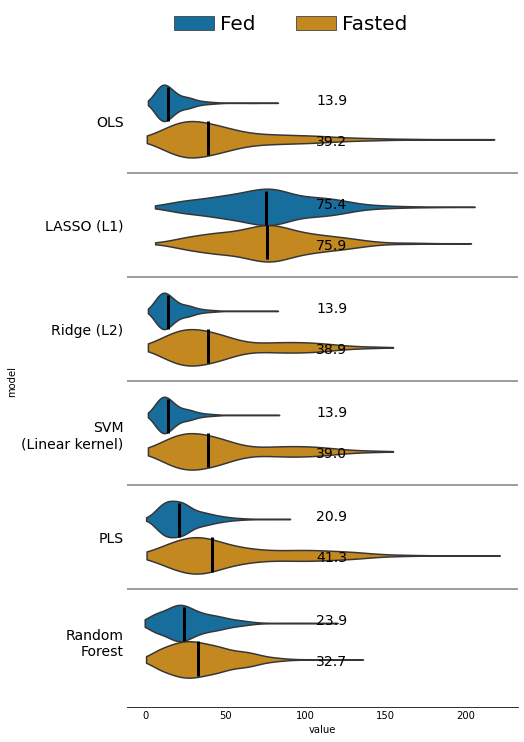

In [241]:
plot_comparison(y='weight', error='neg_mean_squared_error',
                width=0.7, cut=0.3, bw=0.3, annot_loc=0.5, sci_notation_format=False, round_decimal=1,
                split=False)
# plt.xlim(-0.1, 1.1)

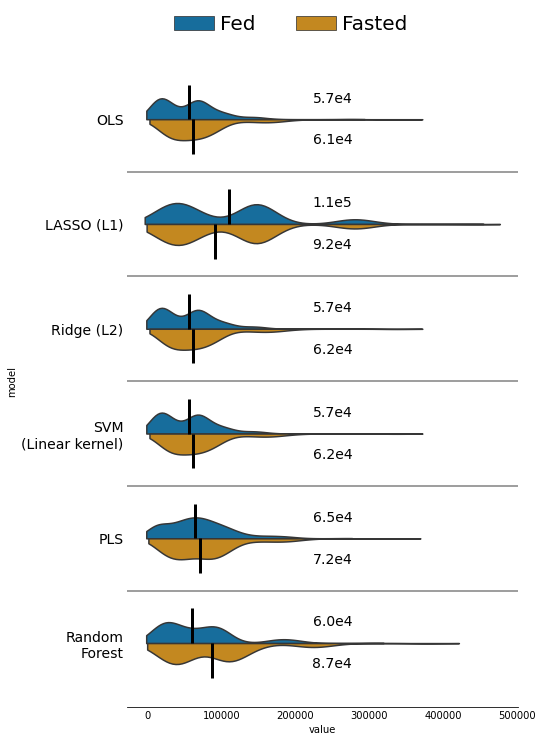

In [231]:
plot_comparison(y='insulin', error='neg_mean_squared_error',
                width=0.4, cut=0.3, bw=0.3, annot_loc=0.5, sci_notation_format=True)

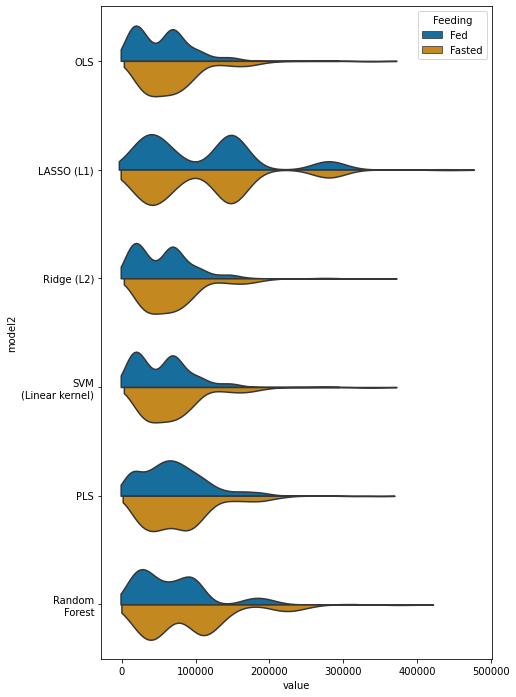

In [129]:
fig, ax = plt.subplots(figsize=(7, 12))
vp = sns.violinplot(
    data=insulin, x='value', y='model2',
    orient='h', split=True, hue='Feeding', width=0.65,
    scale='width', cut=0.4, 
    palette=colors, inner=None,
    ax=ax,
)

In [7]:
lasso['model'] = 'lasso'
rf['model'] = 'rf'
svr['model'] = 'model'
concat = pd.concat([lasso, rf, svr])
concat['Feeding'] = concat['variable'].map({'FBG': 'Fasted', 'RBG': 'Random-fed'})
concat

,variable,value,dummy,model,Feeding
0,FBG,0.376486,dummy,lasso,Fasted
1,FBG,0.194368,dummy,lasso,Fasted
2,FBG,0.286964,dummy,lasso,Fasted
3,FBG,0.366897,dummy,lasso,Fasted
4,FBG,0.168847,dummy,lasso,Fasted
...,...,...,...,...,...
595,RBG,0.161203,dummy,model,Random-fed
596,RBG,0.153347,dummy,model,Random-fed
597,RBG,0.122726,dummy,model,Random-fed
598,RBG,0.461233,dummy,model,Random-fed


In [98]:
d = {}
for df, name in zip([lasso, rf, svr], ['lasso', 'rf', 'svr']):
    d[name] = {}
    d[name]['rbg_mean'] = df.loc[df['variable'] == 'RBG', 'value'].mean()
    d[name]['fbg_mean'] = df.loc[df['variable'] == 'FBG', 'value'].mean()

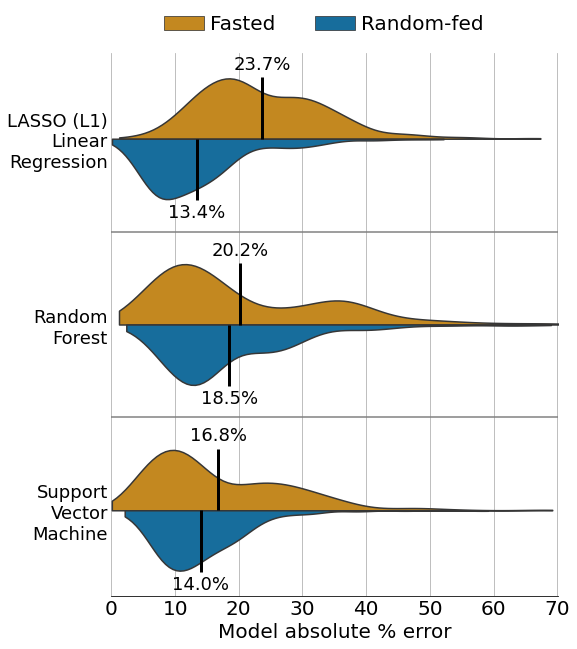

In [111]:
fig, ax = plt.subplots(figsize=(8, 10))

vp = sns.violinplot(
    data=concat, x='value', y='model',
    orient='h', split=True, hue='Feeding', width=0.65,
    scale='width', cut=0.4, 
    palette=colors, inner=None,
    ax=ax,
)

for i, model in enumerate(['lasso', 'rf', 'svr']):
    fbg_mean = d[model]['fbg_mean']
    rbg_mean = d[model]['rbg_mean']
    plt.plot([fbg_mean, fbg_mean], [i, i - 0.33], linewidth=3, color='black', solid_capstyle='butt')
    plt.plot([rbg_mean, rbg_mean], [i, i + 0.33], linewidth=3, color='black', solid_capstyle='butt')
    plt.annotate(str(round(fbg_mean*100, 1)) + '%', xy=(fbg_mean, i - 0.4), ha='center', va='center', fontsize=18)
    plt.annotate(str(round(rbg_mean*100, 1)) + '%', xy=(rbg_mean, i + 0.4), ha='center', va='center', fontsize=18)
plt.axhline(y=0.5, color='gray')
plt.axhline(y=1.5, color='gray')
plt.xlim(0, 0.701)
plt.xticks(ticks=plt.xticks()[0][:-1], labels=[str(x) for x in range(0, 80, 10)], fontsize=20)
plt.xlabel('Model absolute % error', fontsize=20)
# plt.ylabel('Model', fontsize=18)
plt.ylabel(None)
plt.yticks(ticks=[0,1,2], 
           labels=['LASSO (L1)\nLinear\nRegression', 'Random\nForest', 'Support\nVector\nMachine'],
           fontsize=18, ha='right')
plt.tick_params(axis='both', length=0)
plt.grid(axis='x', visible=None, ) 
ax.set_axisbelow(True)  # puts grid behind the violins, because zorder doesn't work. 
plt.legend(loc=(0.1, 1.02), markerscale=3, fontsize=20, frameon=False, ncol=2, handletextpad=0.3)
sns.despine(left=True, bottom=False)

plt.savefig(r'../reports/figures/fasted_vs_fed_models/combined.png', bbox_inches='tight', dpi=150)
plt.savefig(r'../reports/figures/fasted_vs_fed_models/combined.svg', bbox_inches='tight', dpi=150)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
vp = sns.violinplot(
data=errors, x='value', y='dummy',
orient='h', split=True, hue='variable',
scale='width', cut=0.4,
palette=colors, 
inner=None, 
ax=ax
)
plt.axvline(x=mean_fbg, ymin=0.5, ymax=0.95, c='black', linewidth=3, solid_capstyle='butt')
plt.axvline(x=mean_rbg, ymin=0.1, ymax=0.5, c='black', linewidth=3, solid_capstyle='butt')
plt.annotate(text=str(round(mean_fbg*100, 1)) + '%', xy=(mean_fbg, plt.ylim()[1]), 
             ha='center', va='center', fontsize=18, )
plt.annotate(text=str(round(mean_rbg*100, 1)) + '%', xy=(mean_rbg, plt.ylim()[0]*0.93), 
             ha='center', va='center', fontsize=18)

ax.set_yticks([])
ax.set_xlim((0, ax.get_xlim()[1]))
# ax.set_xticks(ticks=ax.get_xticks()[:-1], labels=[int(x*100) for x in ax.get_xticks()][:-1], fontsize=16)
ax.set_xticks(ticks=np.arange(0, 0.75, 0.1), labels=range(0, 80, 10), fontsize=16)
ax.tick_params(axis='x', length=0)
ax.set_ylabel(None)
ax.set_xlabel(None)

ax.get_legend().remove()
plt.grid()

sns.despine(left=True, bottom=True, ax=ax)
